# Model Development & Experimentation

### 1. Problem Understanding

The goal of this project is to build a real-time computer vision model that can detect bottle caps and classify them into three color-based categories:
- Light Blue
- Dark Blue
- Others

The dataset includes images and YOLO-format bounding boxes, but the labels must be modified based on color.
A major requirement is that the model should run efficiently on edge devices such as Raspberry Pi 5, achieving 5–10 ms inference per frame.

### 2. Dataset Analysis

Dataset Size <br>
The dataset contains only 12 images, which is extremely small for training an object detection model.
After Roboflow splitting:

Train : 30
Valid : 1
Test : 1

#### Class Imbalance

The dataset is highly imbalanced:
Others → majority class
Light Blue → only 1–2 images
Dark Blue → only 1–2 images

This imbalance increases the risk of:
Overfitting
Poor generalization
Model bias toward “Others”

### 3. Label Preprocessing (Color-based Re-labelling)

Since raw labels only contain bounding boxes, I manually reclassified each bounding box into:

0: light blue

1: dark blue

2: others

This required visually inspecting each object and updating YOLO annotation .txt files before training.

### 4. Preprocessing & Augmentation Strategy

#### Image Preprocessing (Roboflow)

##### Auto Orient
Resize to 640×640

##### Augmentations Applied
Horizontal & vertical flips
Rotation (±15°)
Brightness (±15%)
Exposure (±10%)
Blur (up to 2.5px)

#### Justification

With an extremely small dataset, augmentation is essential to prevent overfitting.

##### Pros
Increases data diversity
Helps balance the dataset (to some extent)
Improves robustness

#### Cons
Augmentation cannot replace real data
Still not enough variety for reliable minority classes

### 5. Model Architecture Choice: YOLOv8n

#### I selected YOLOv8n (nano) as the base architecture.

#### Why YOLOv8n?

Fastest variant of YOLOv8 → meets edge device constraints
Lightweight (~3 MB) → ideal for Raspberry Pi
Good accuracy-to-speed ratio
Supports dropout, Adam optimizer, and advanced training settings

#### Expected Inference Speed
On Raspberry Pi 5:
YOLOv8n: 5–10 ms per frame (640×640)
Good enough for real-time detection (100+ FPS)

On my machine, inference results will be reported in **README.md.**

### Weights & Biases (W&B)

W&B is used for experiment tracking, model monitoring, and versioning when training machine learning models.

In [1]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\USER\_netrc
wandb: Currently logged in as: alex-mario1404 (alex-mario) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\USER\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from ultralytics import settings

settings.update({'wandb': True})

### 6. Training Setup

**Why imgsz = 224?**

To further reduce inference time for Raspberry Pi.
YOLOv8n performs well even at low resolutions when objects are large enough.

**Optimizer: Adam**

Chosen for stability with small datasets.
SGD tends to require more data to converge reliably.

**Dropout = 0.15**

Helps reduce overfitting given the extremely small dataset.

**Patience = 20**

Stops early if validation performance stagnates.

In [12]:
from ultralytics import YOLO

# Load model YOLOv8n
model = YOLO("yolov8n.pt")  # bisa ganti yolov8s.pt, yolov8m.pt, dll.

# Training
model.train(
    data="data.yaml",
    epochs=100,                       # dari train.epochs
    batch=16,                         # dari train.batch_size
    imgsz=224,                        # dari model.imgsz
    lr0=0.0001,                       # dari model.lr0
    optimizer="Adam",                 # dari model.optimizer
    dropout=0.15,                     # dari model.dropout
    patience=20,                      # dari model.patience
    verbose=True,
    project="Bottle-Caps-Detection",  # dari train.wandb_project
    name="run5"                       # dari train.run_name
)


Ultralytics 8.3.228  Python-3.11.5 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-12400F)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.15, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run4, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretraine

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

lr/pg0,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
lr/pg1,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
lr/pg2,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
metrics/mAP50(B),▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇████████████████████████
metrics/mAP50-95(B),▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇████████████████████████
metrics/precision(B),▁▁▁▁▁▁▁▁▁▁▁▁▁███████▇▇▆▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅
metrics/recall(B),▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇████████████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000014B5AA88A90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### Training Result

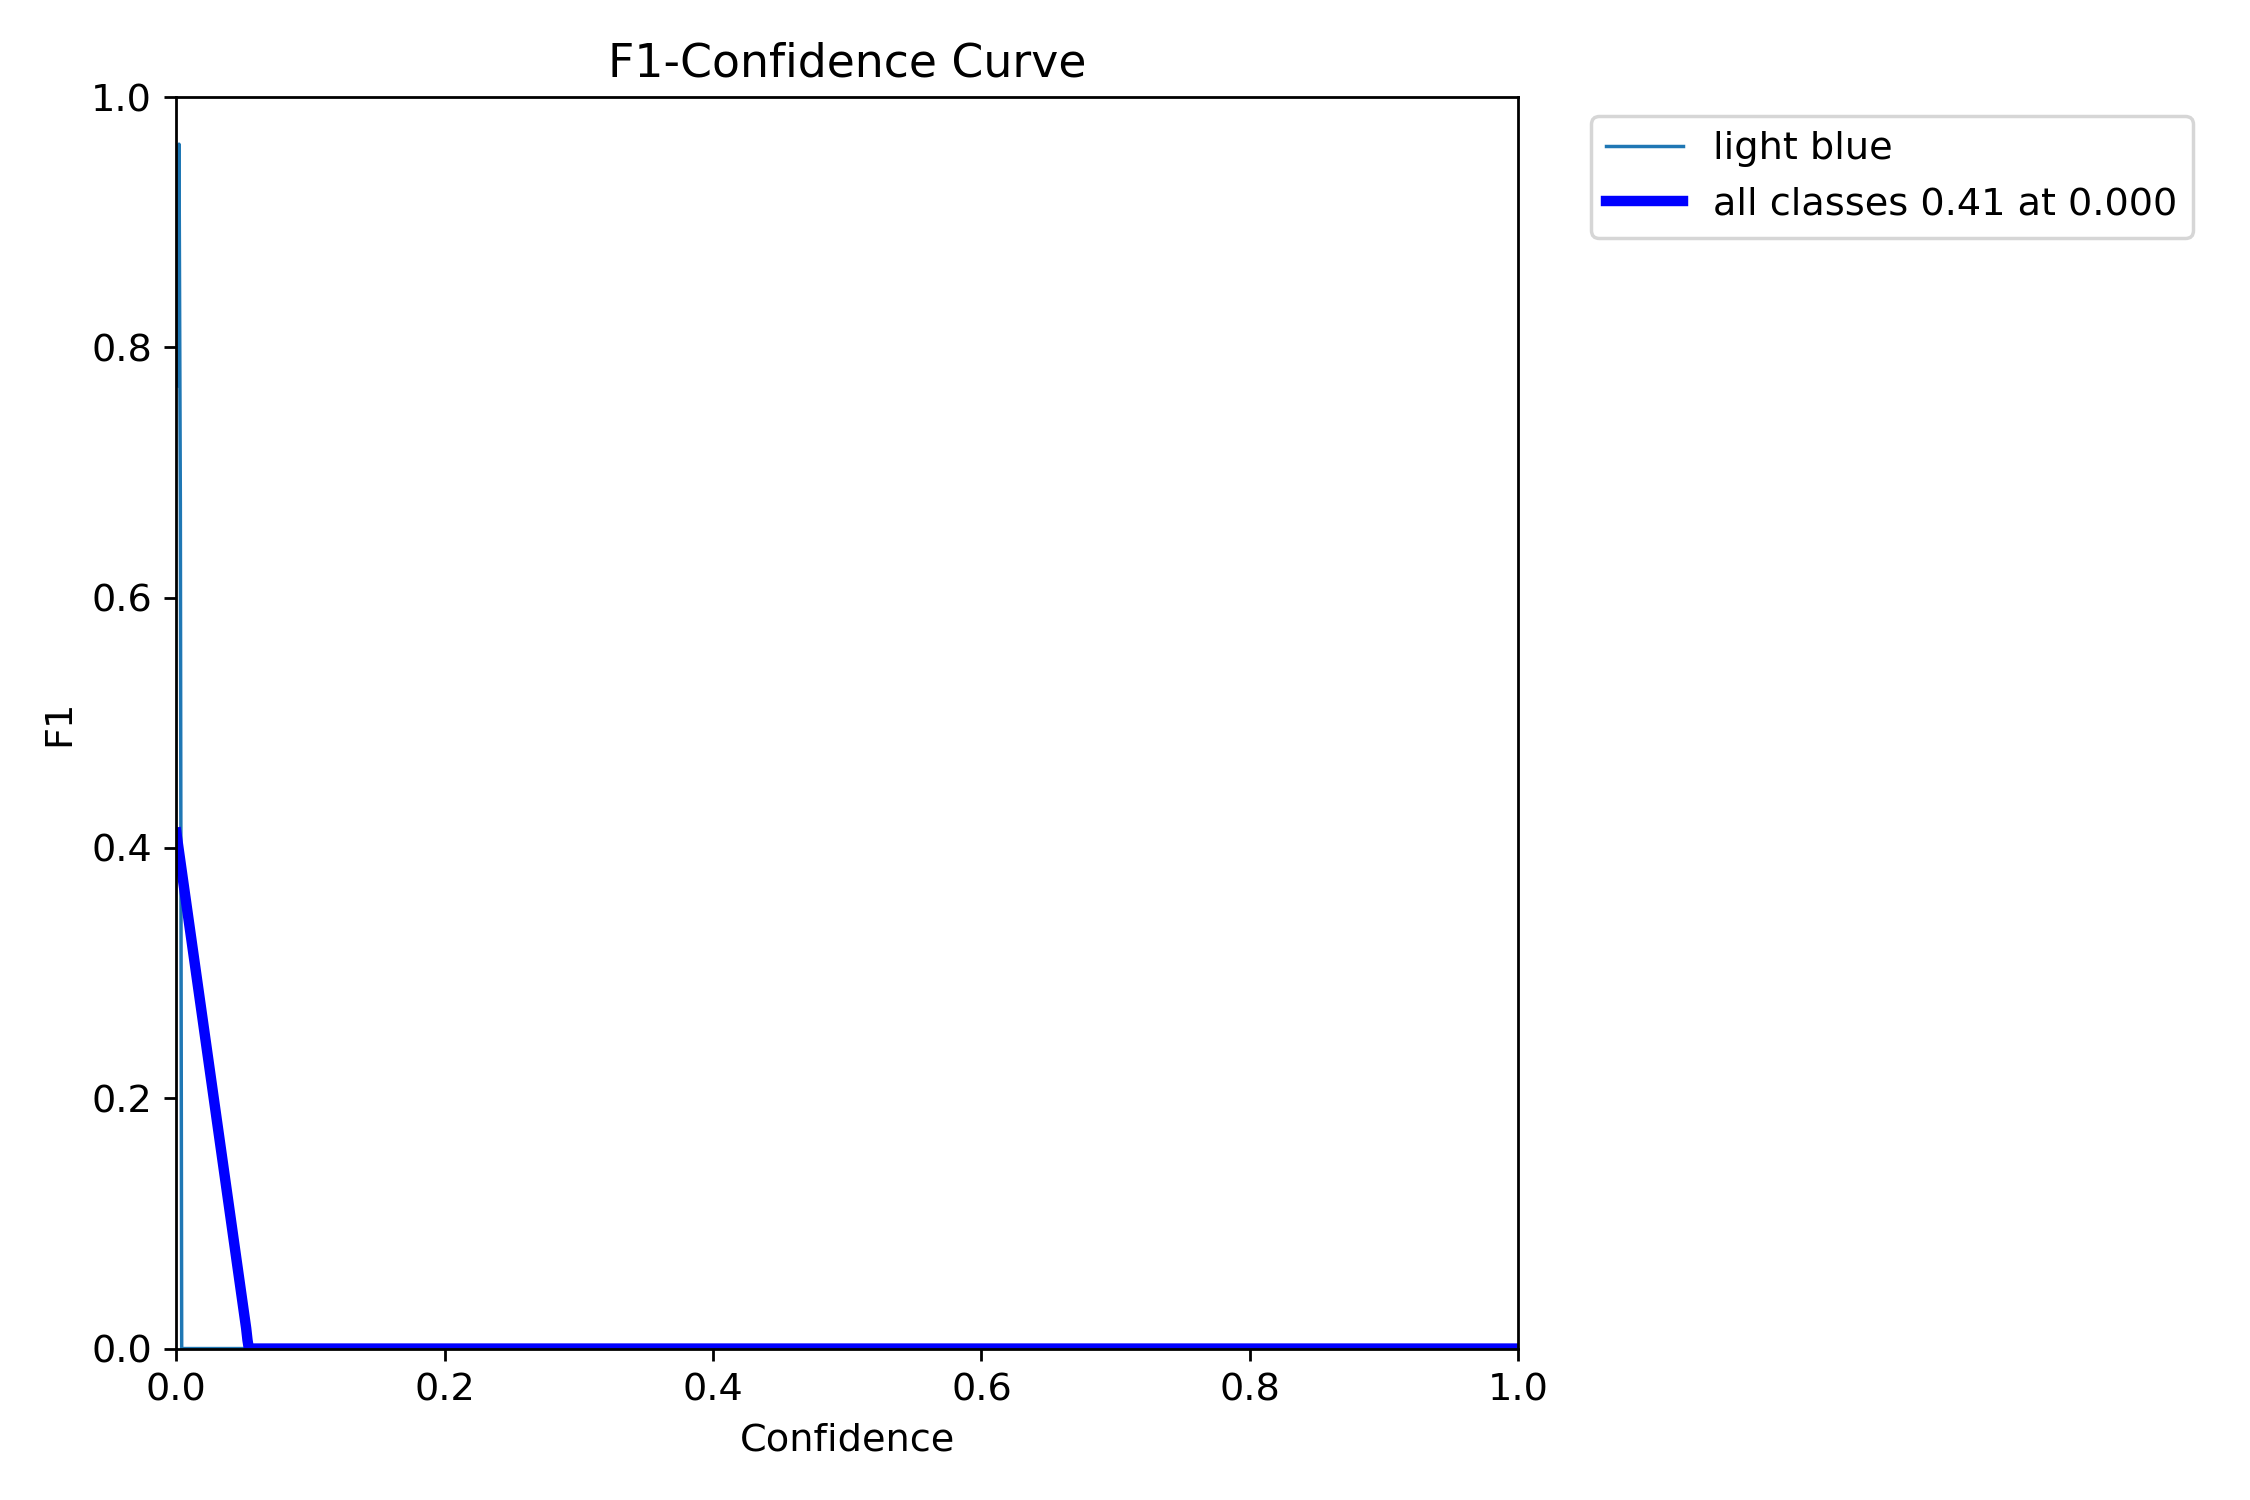

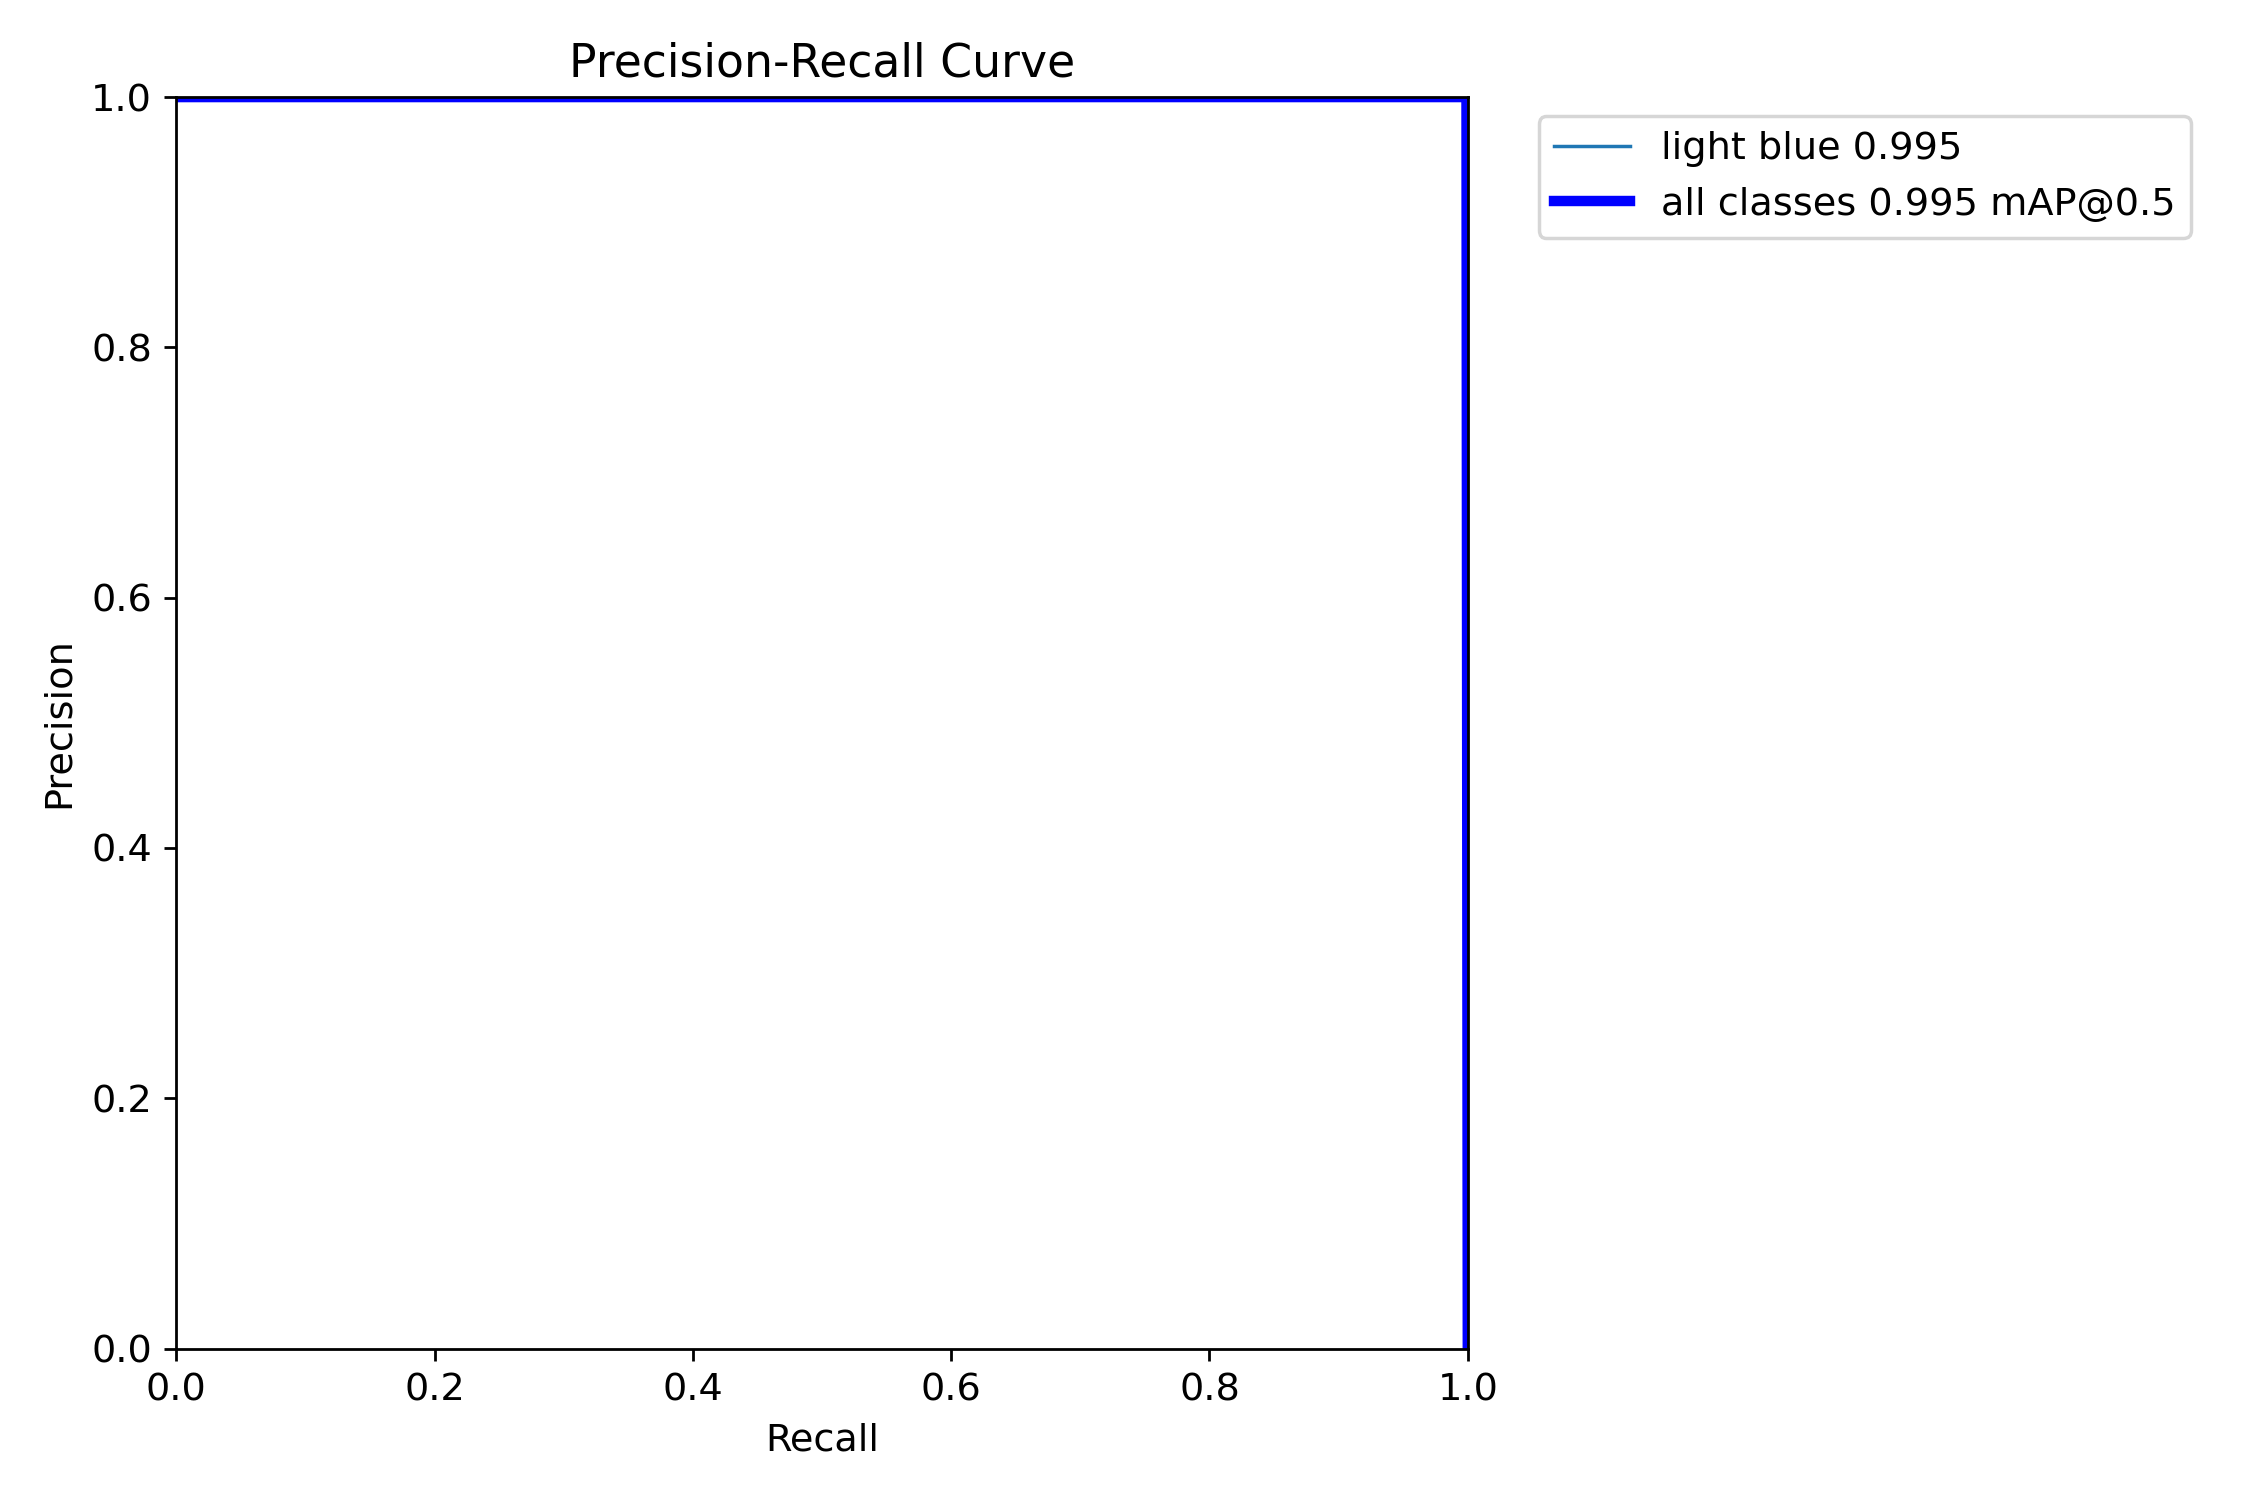

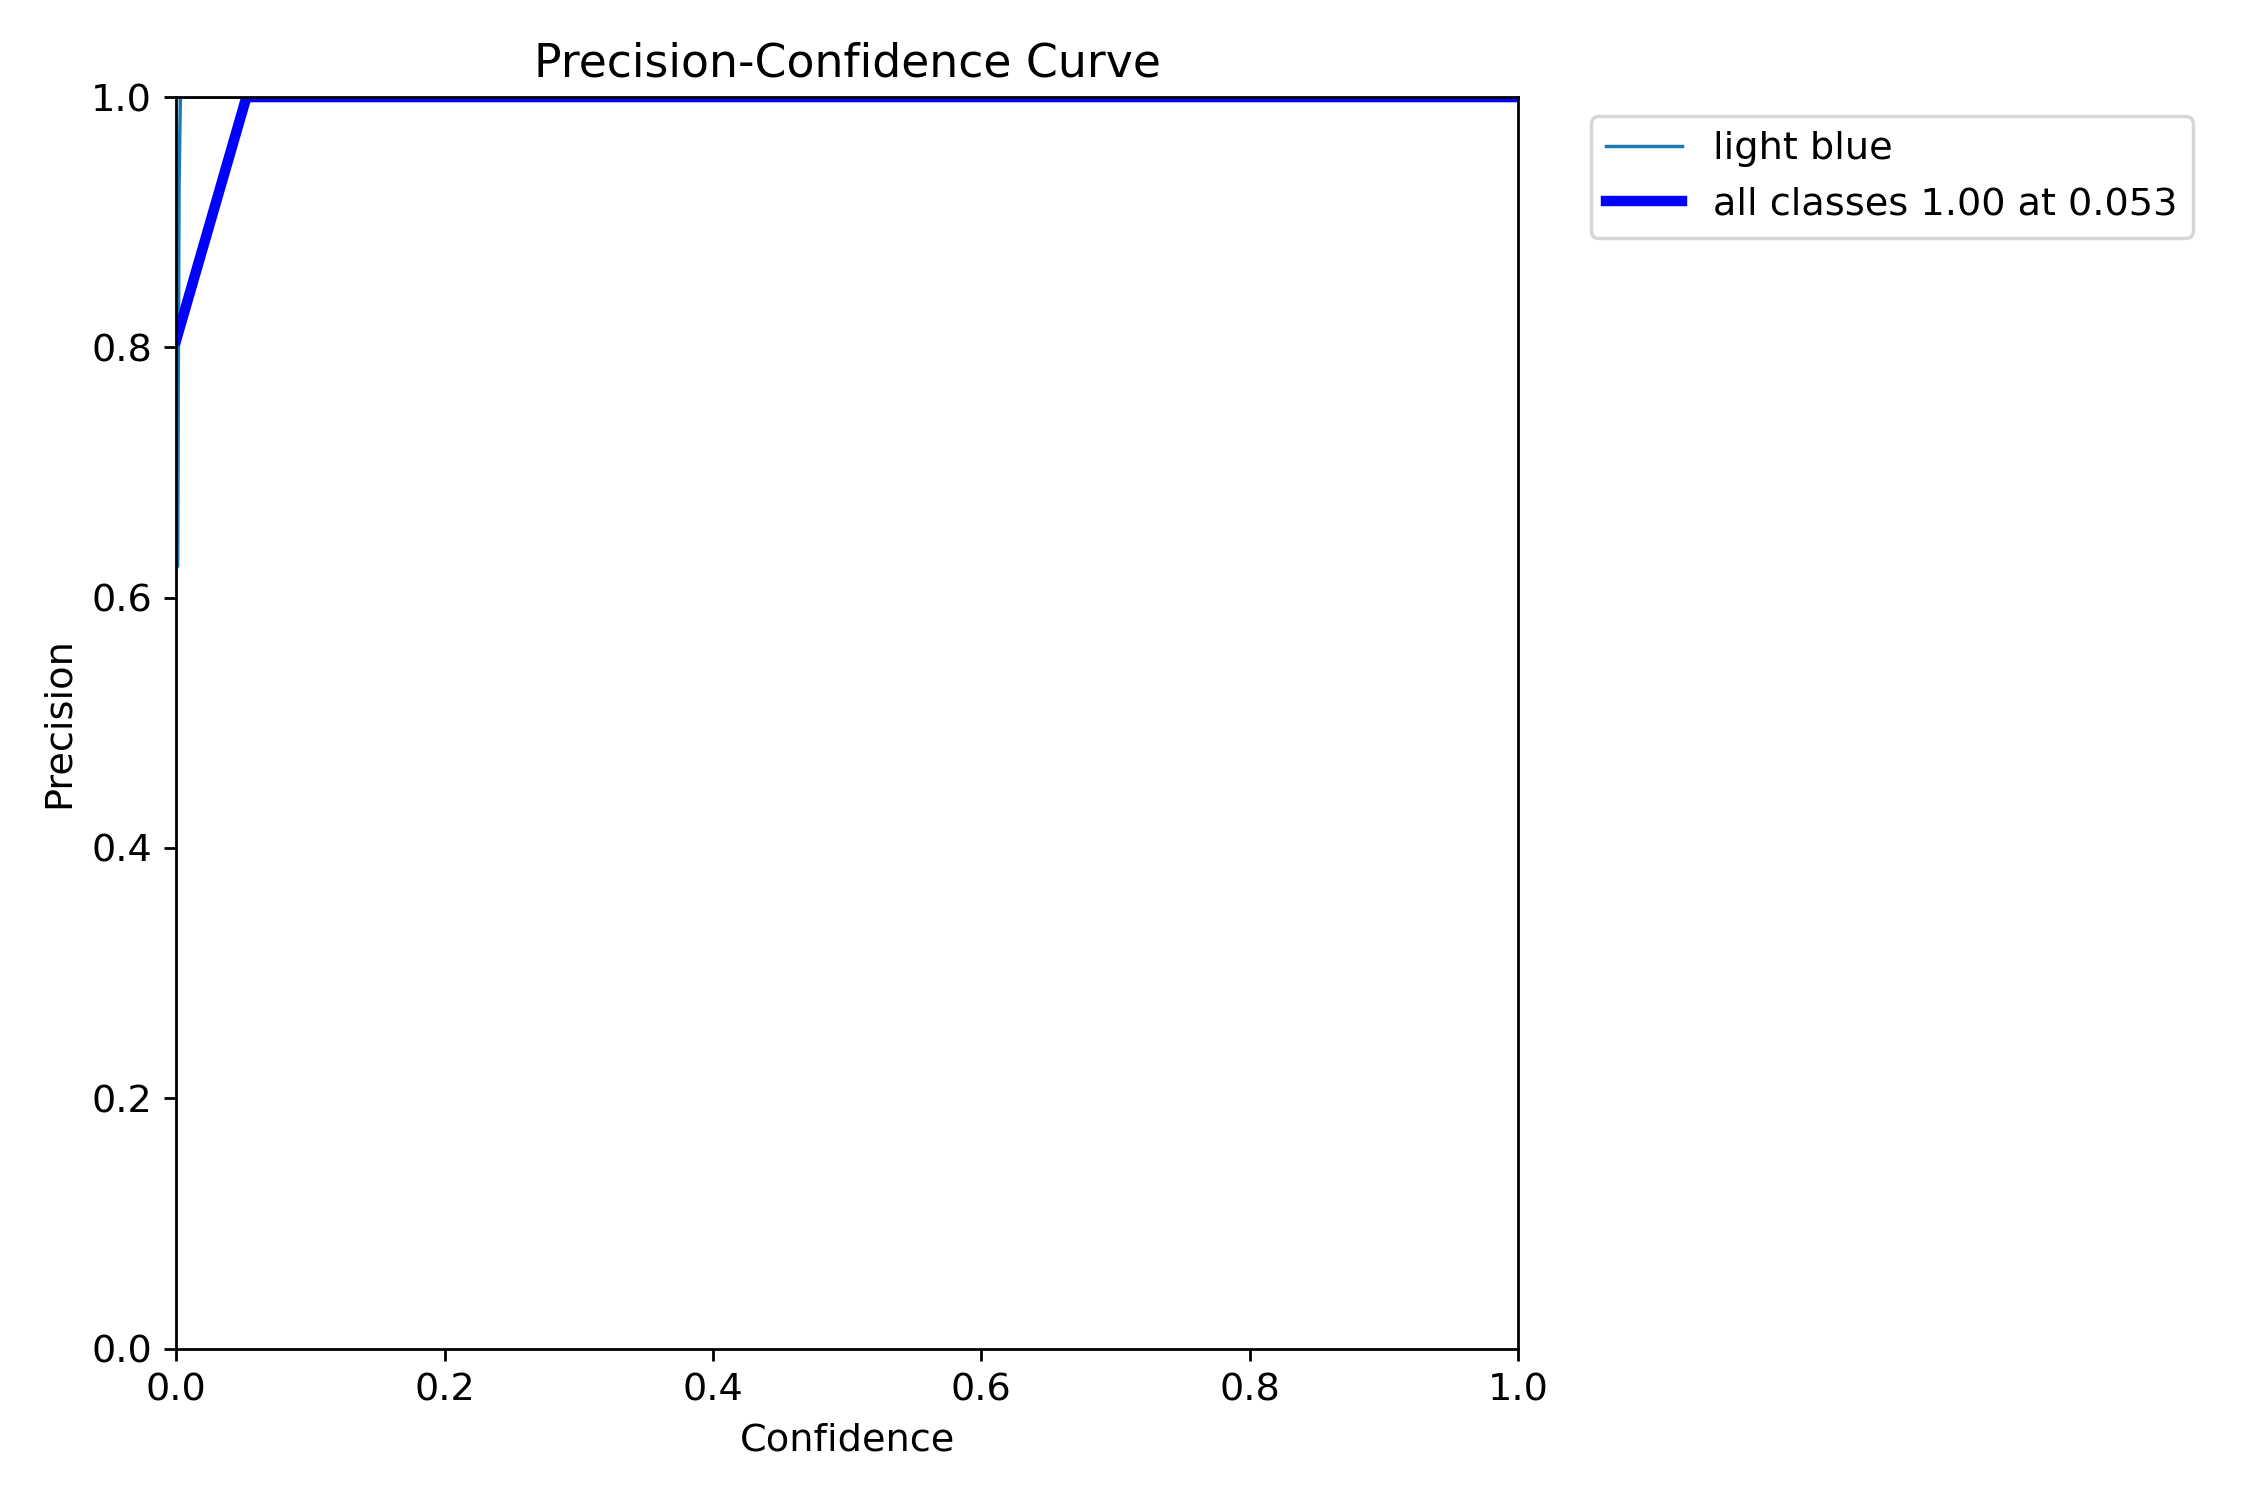

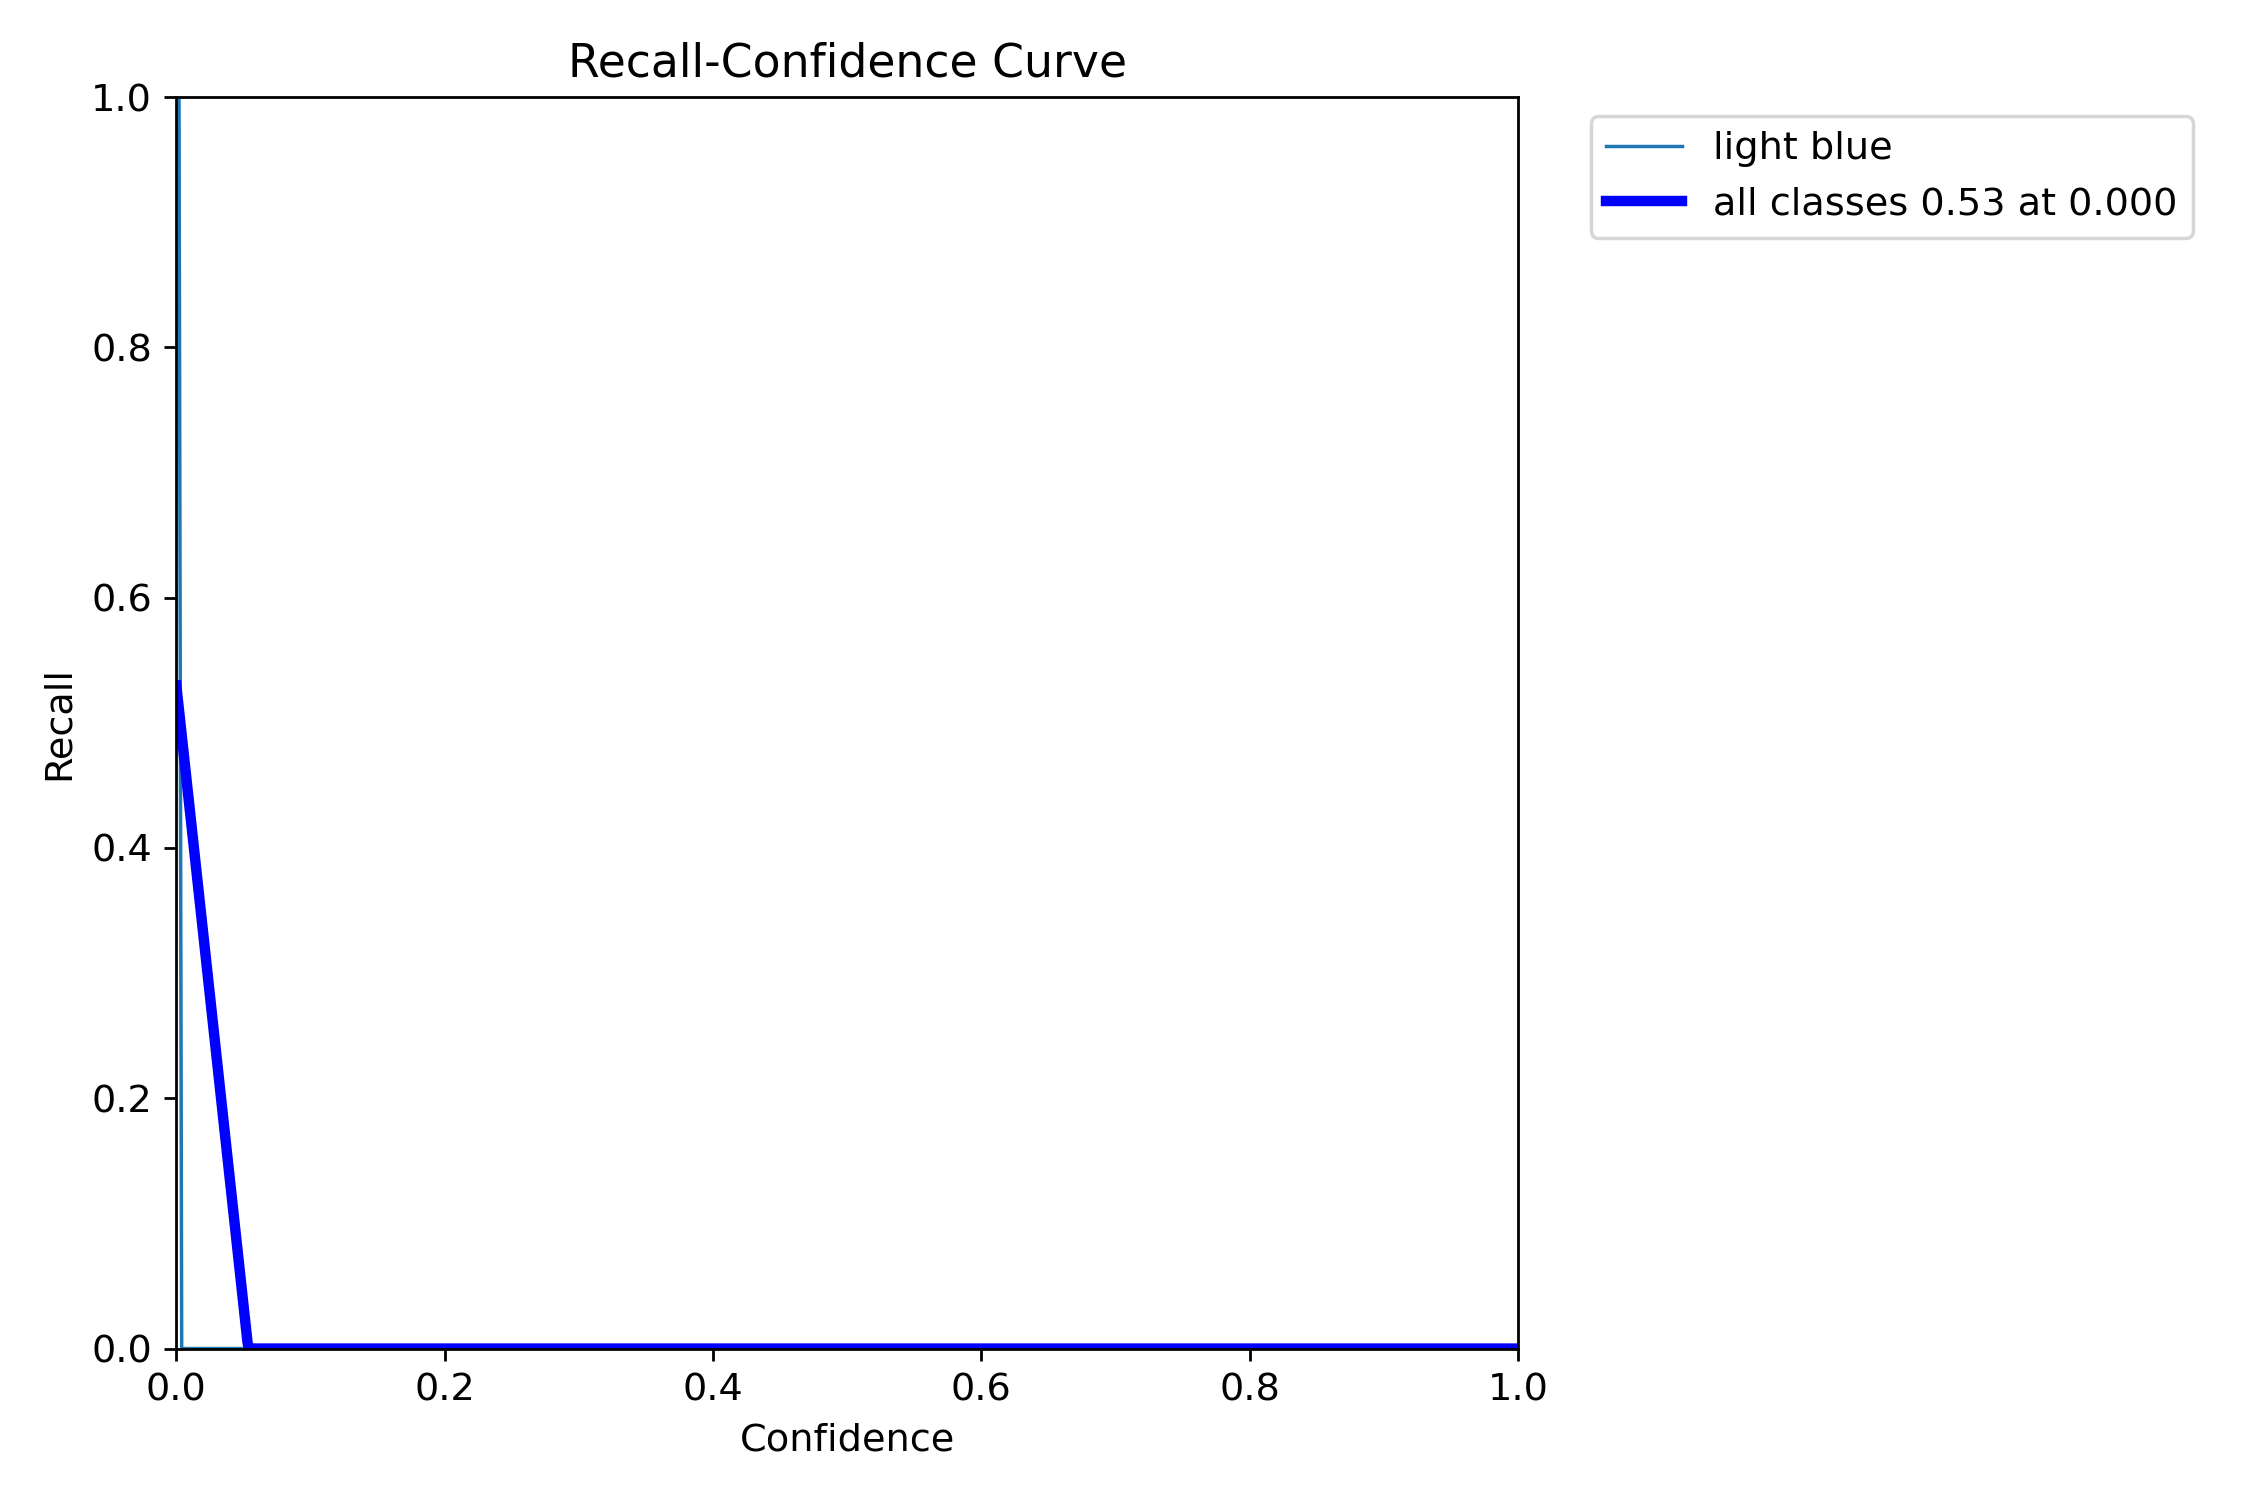

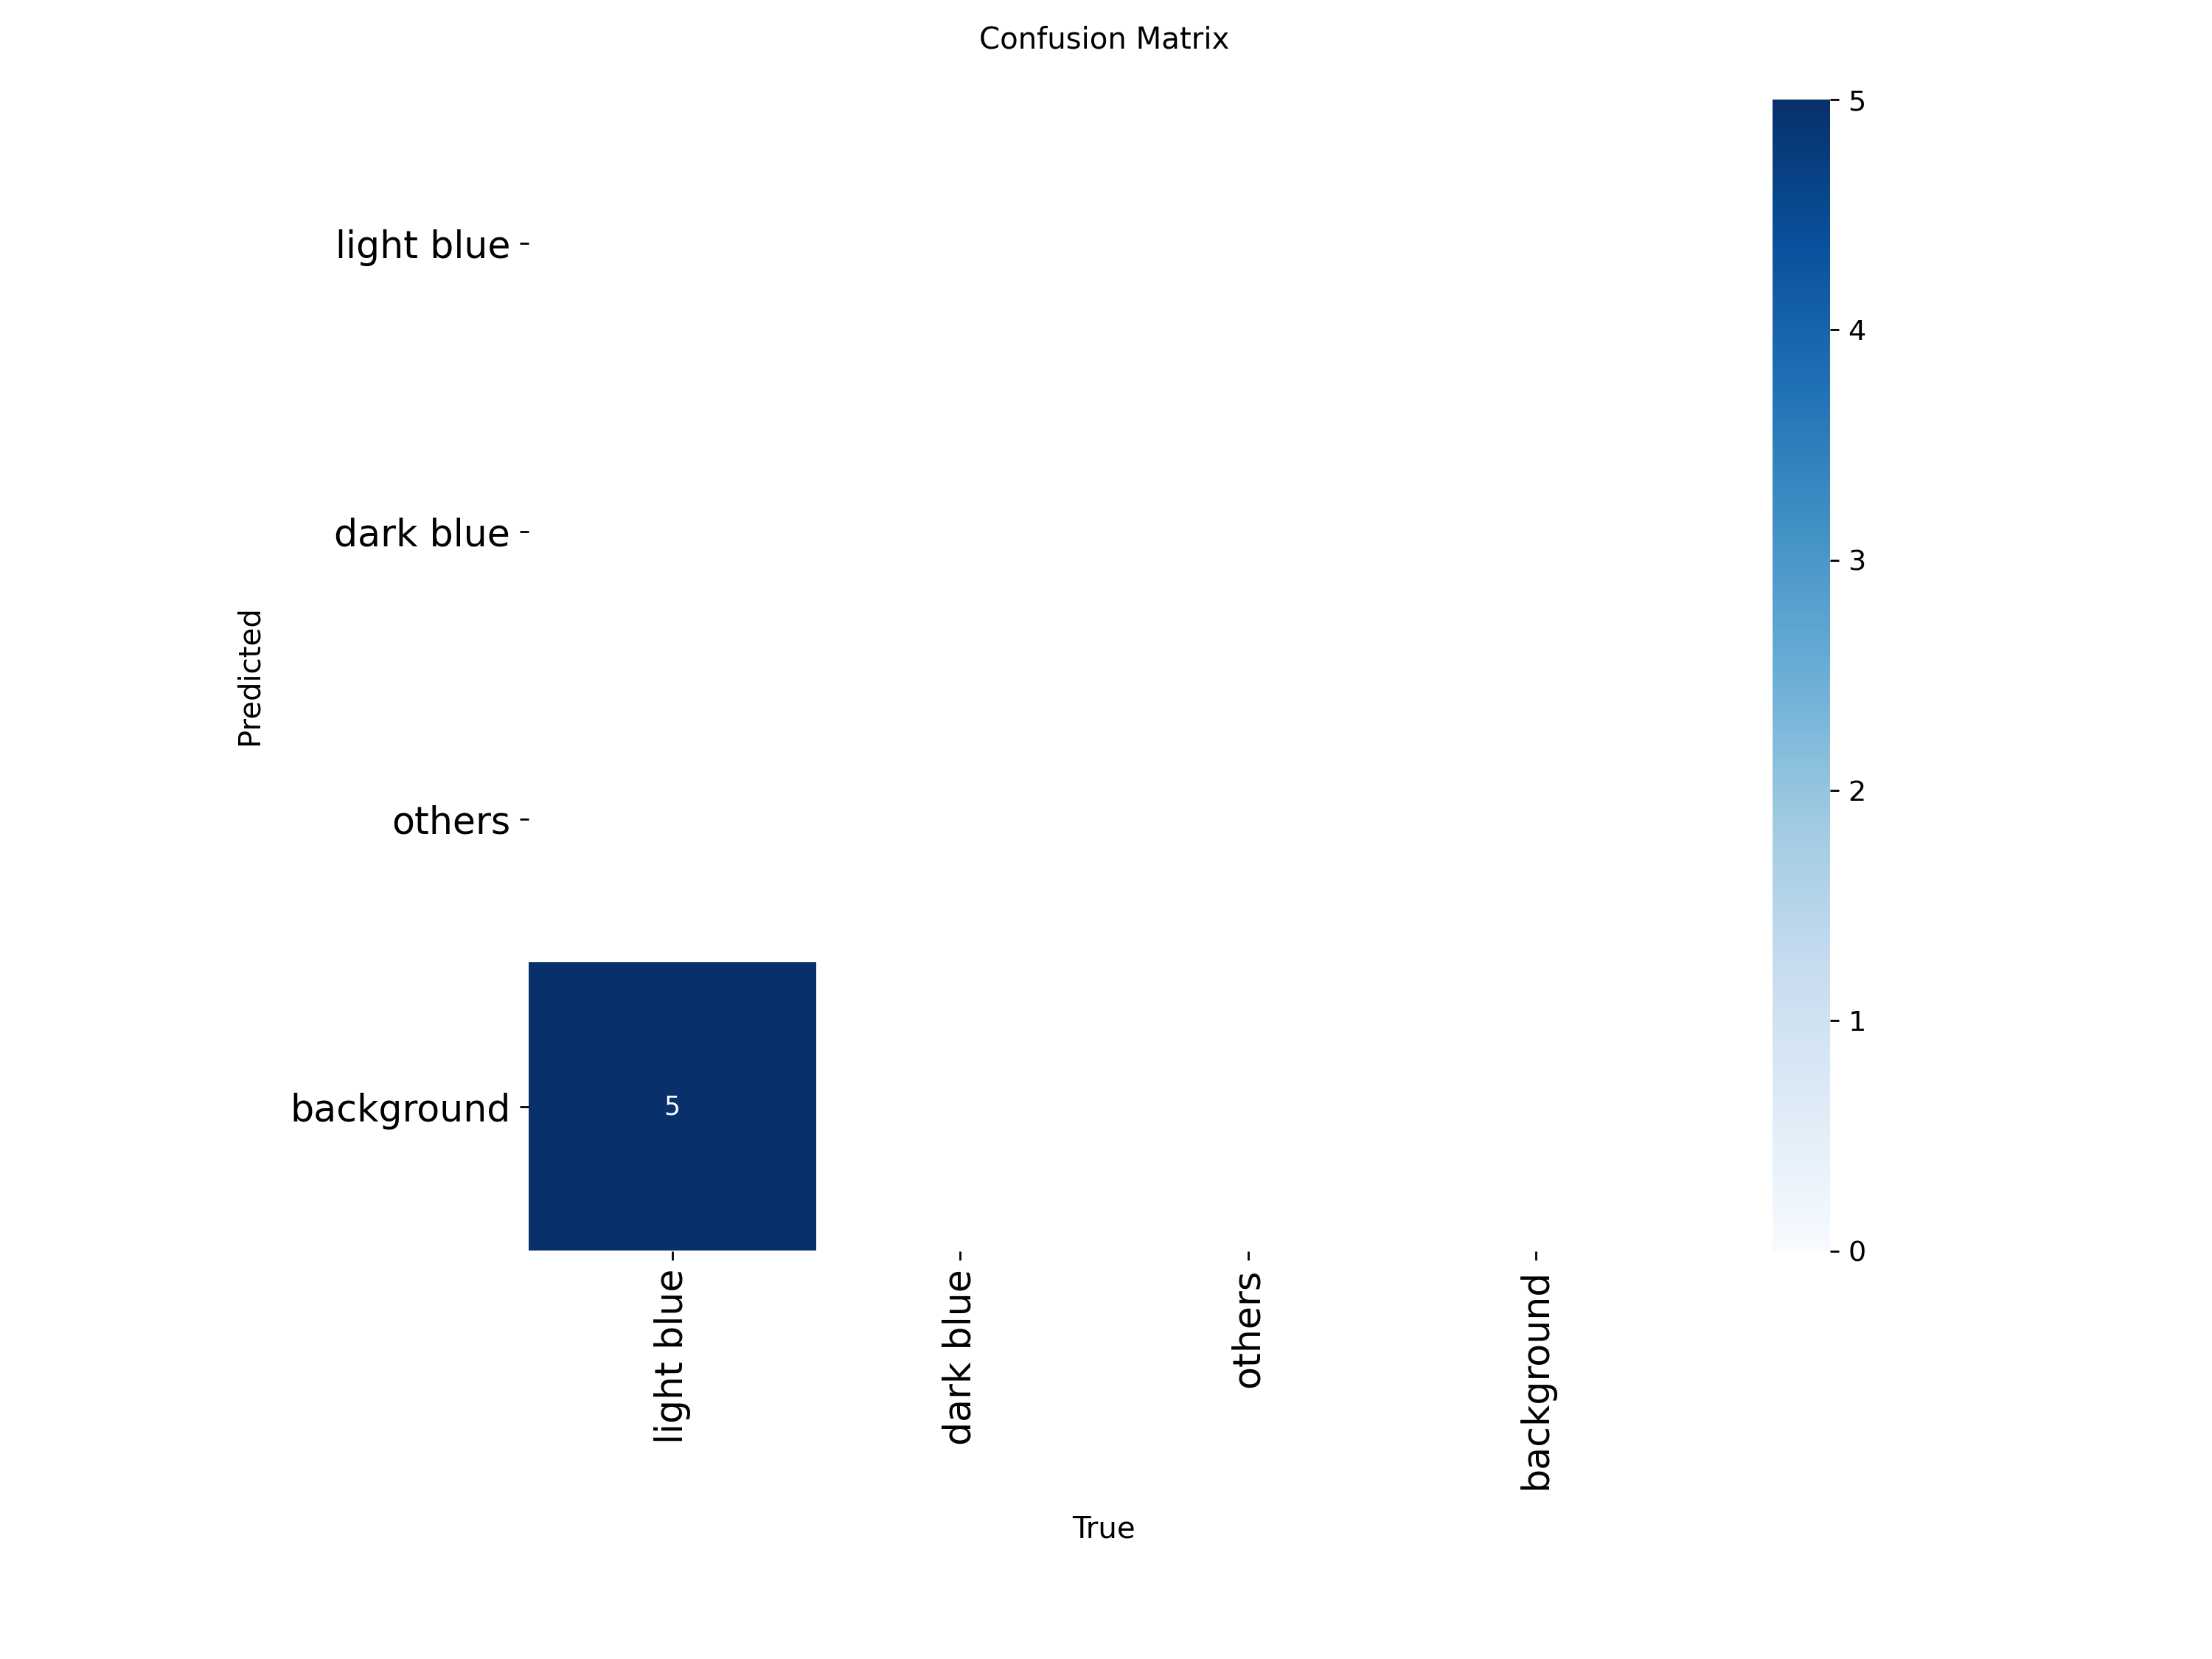

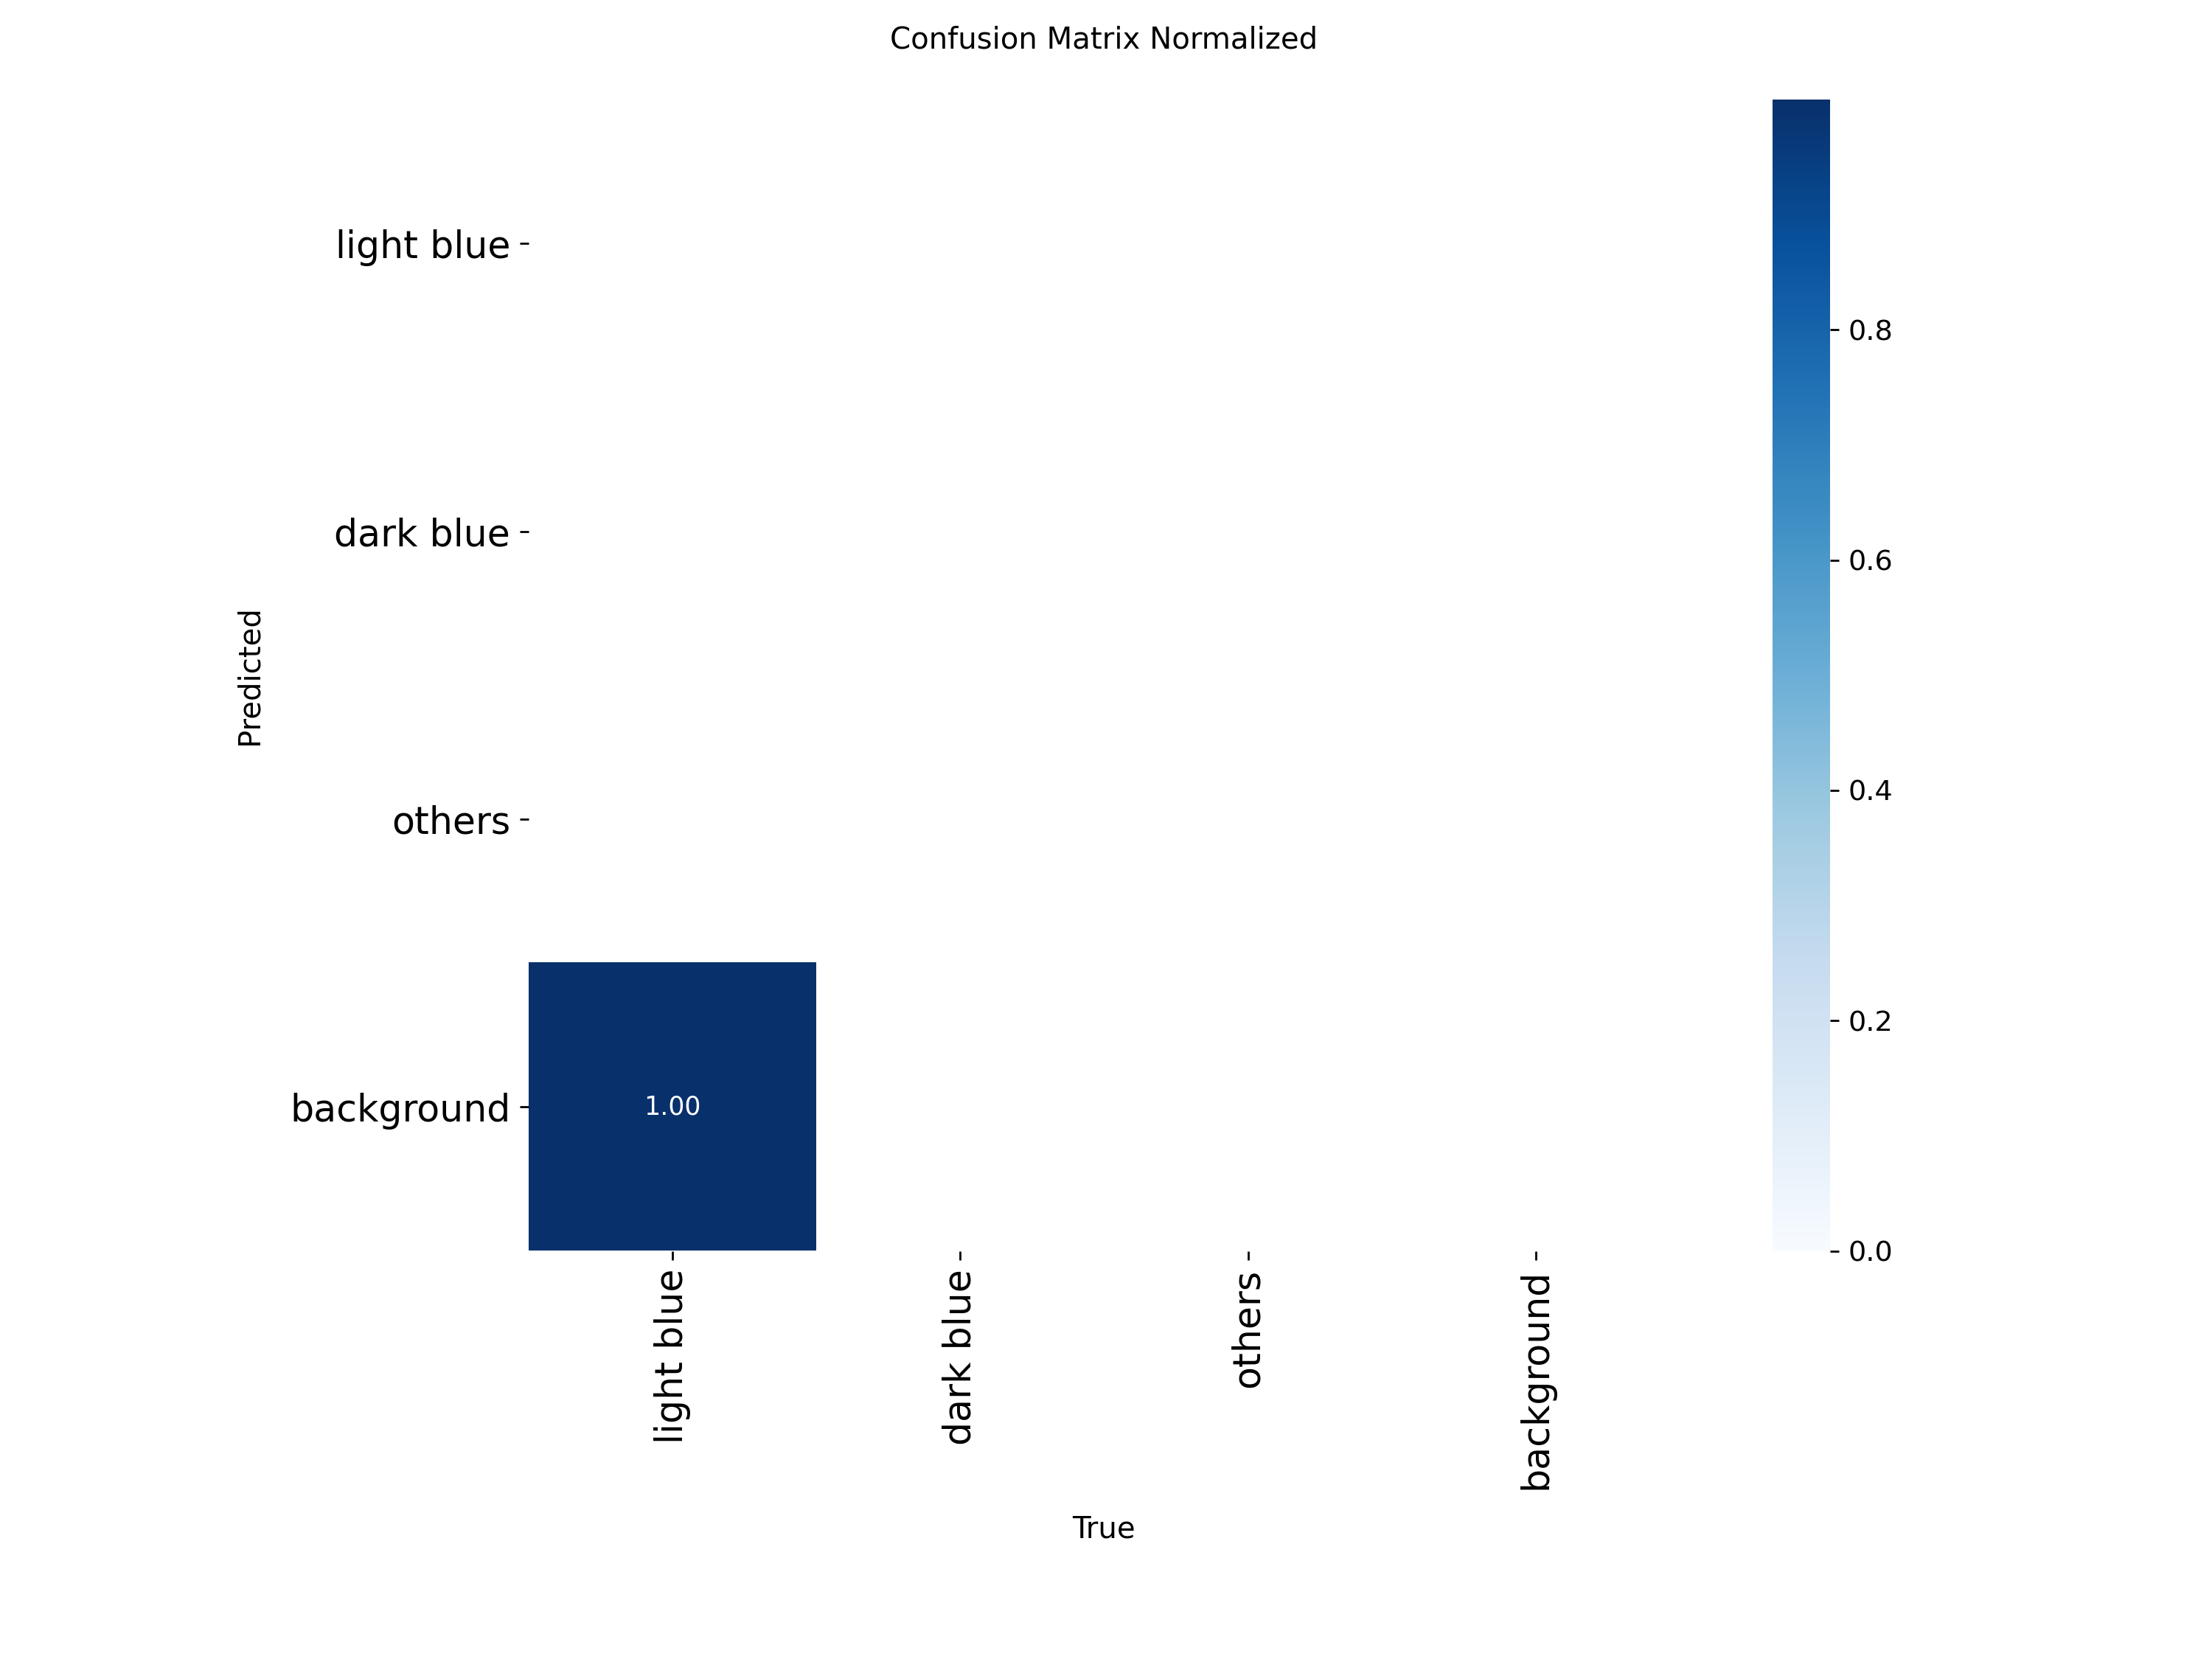

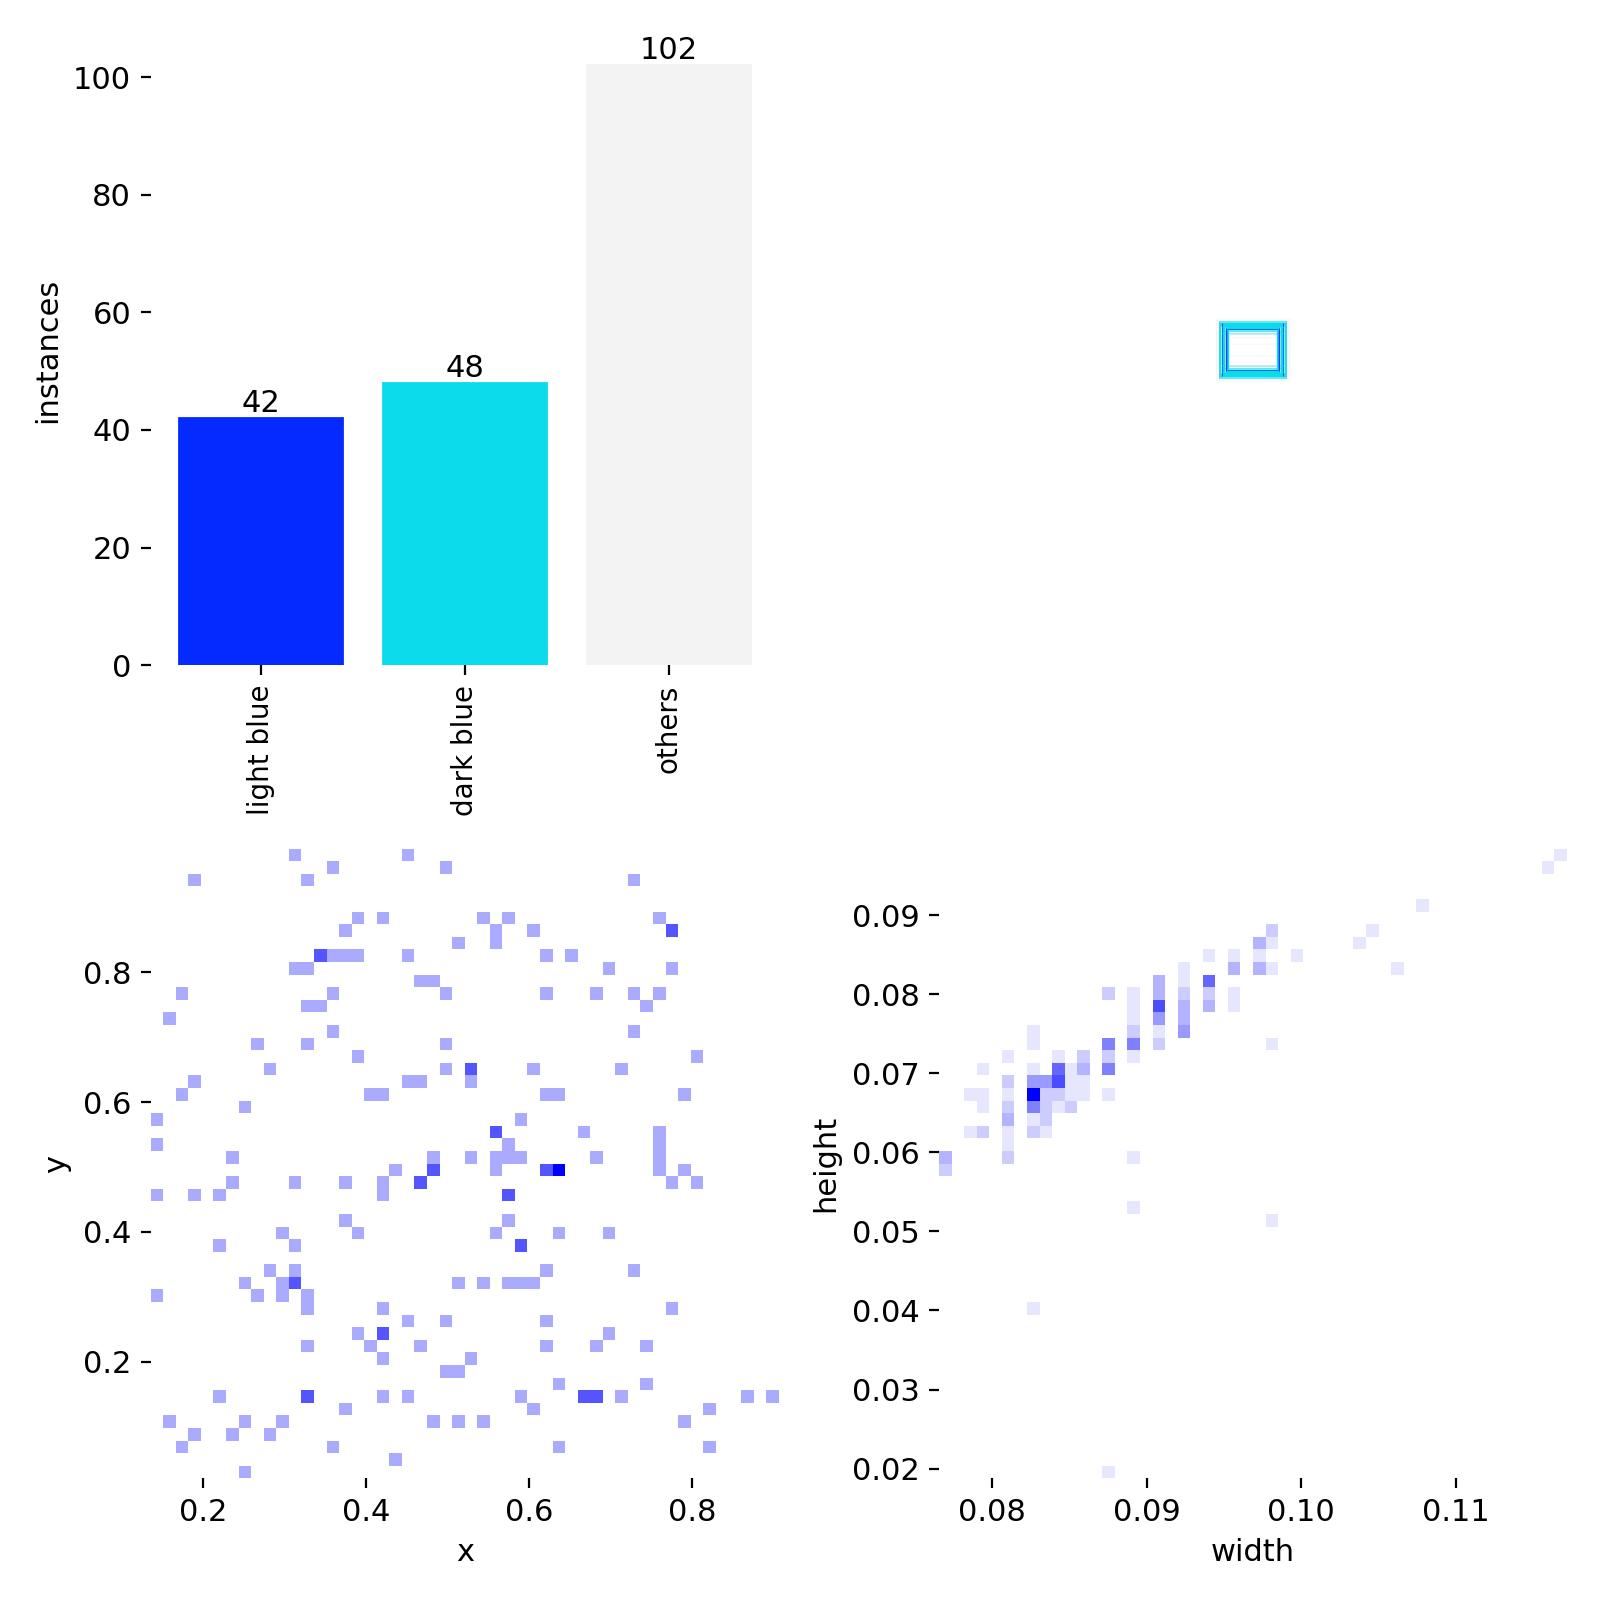

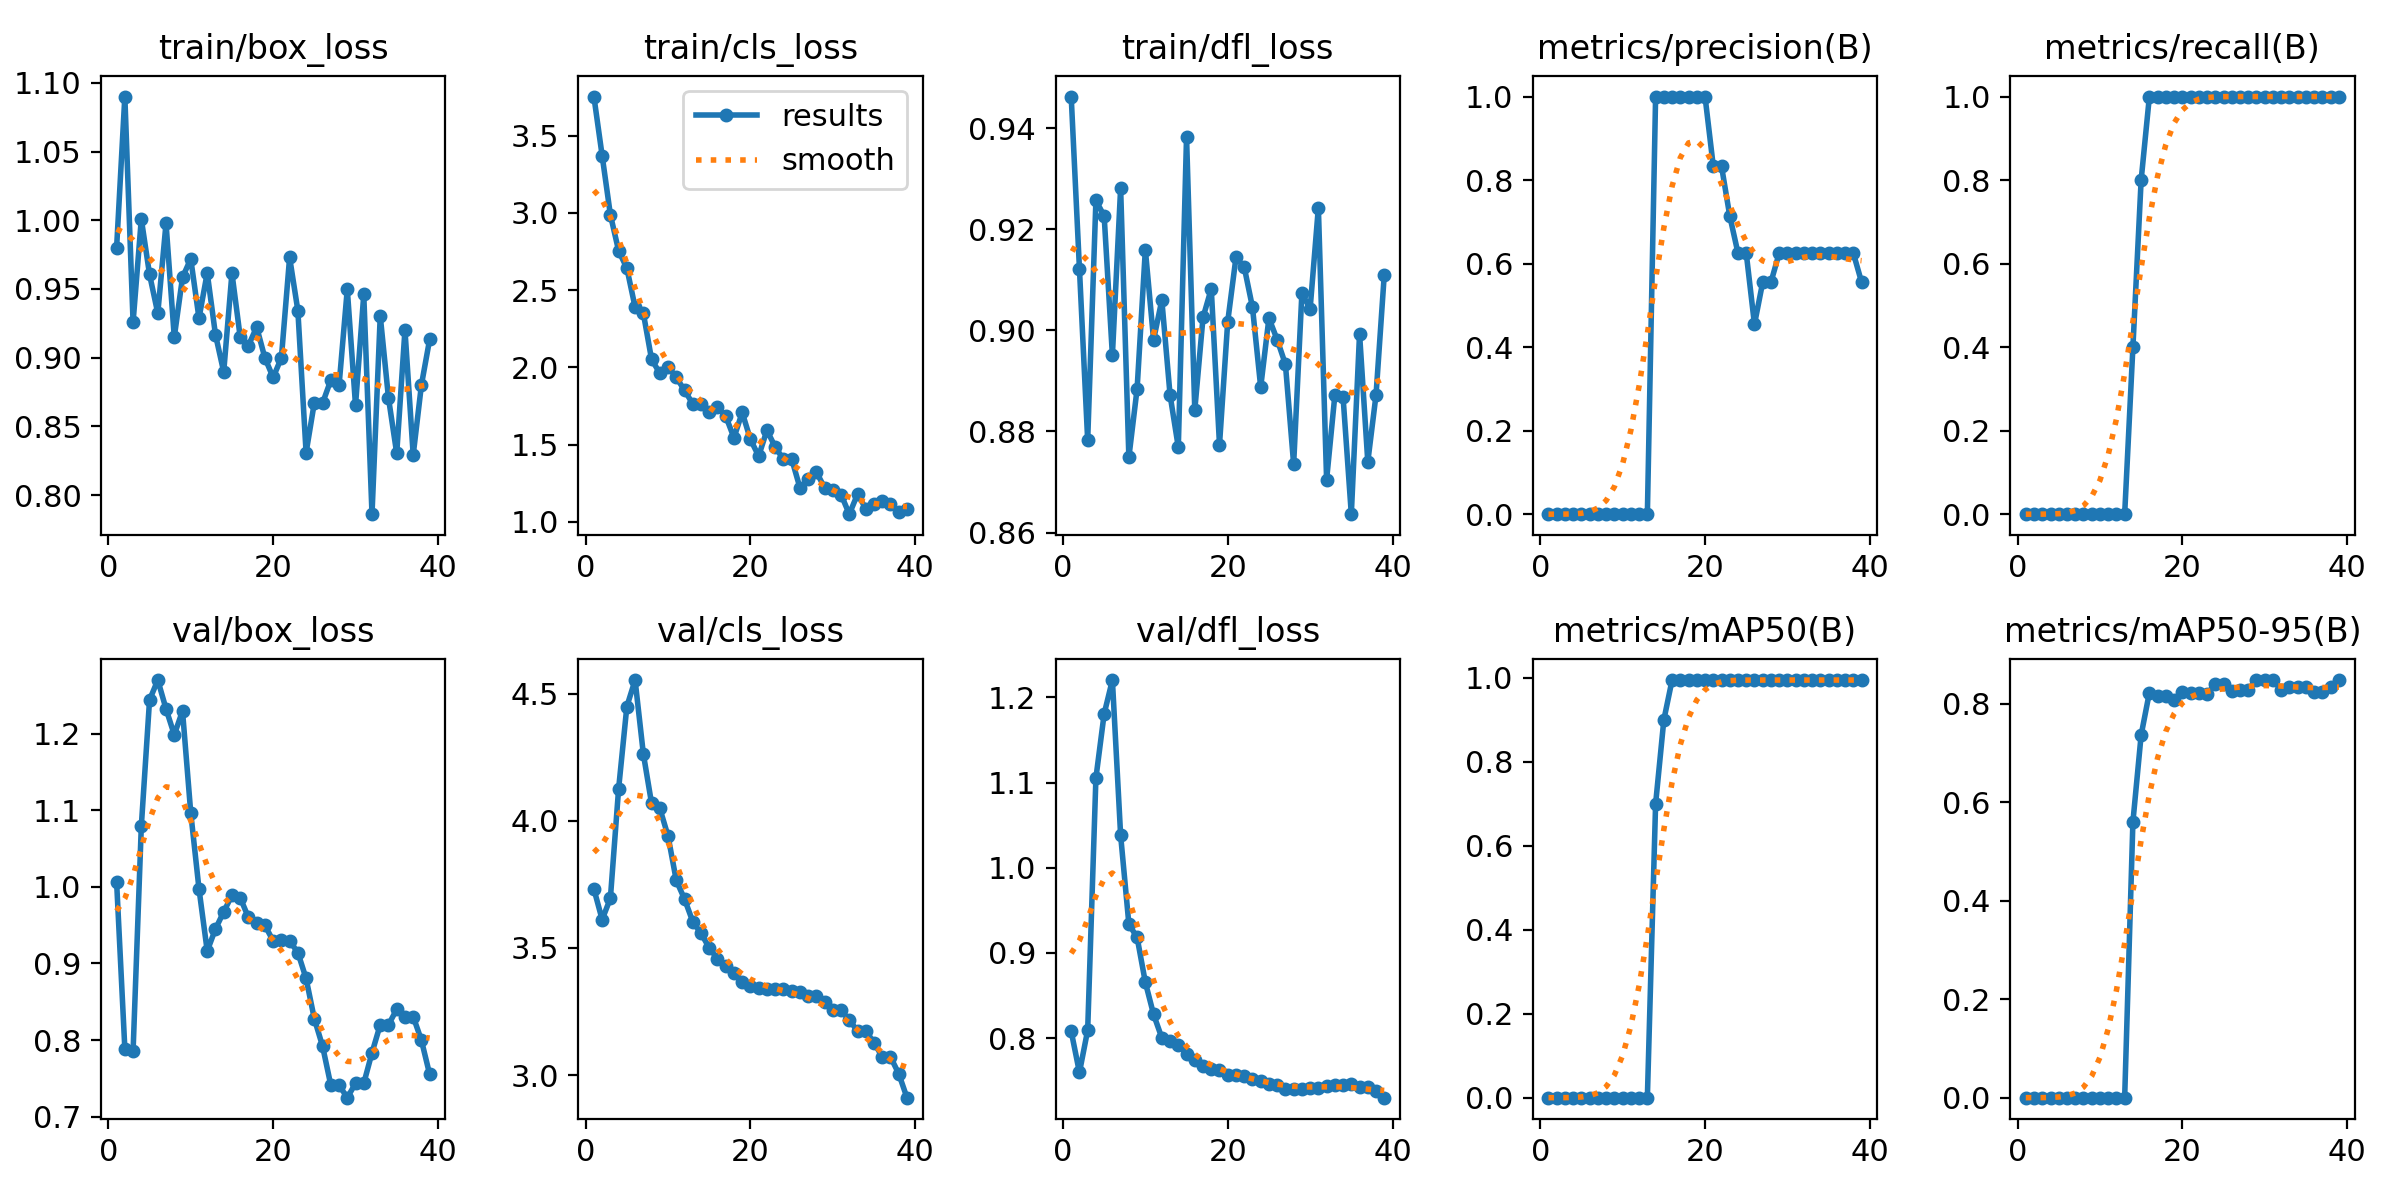

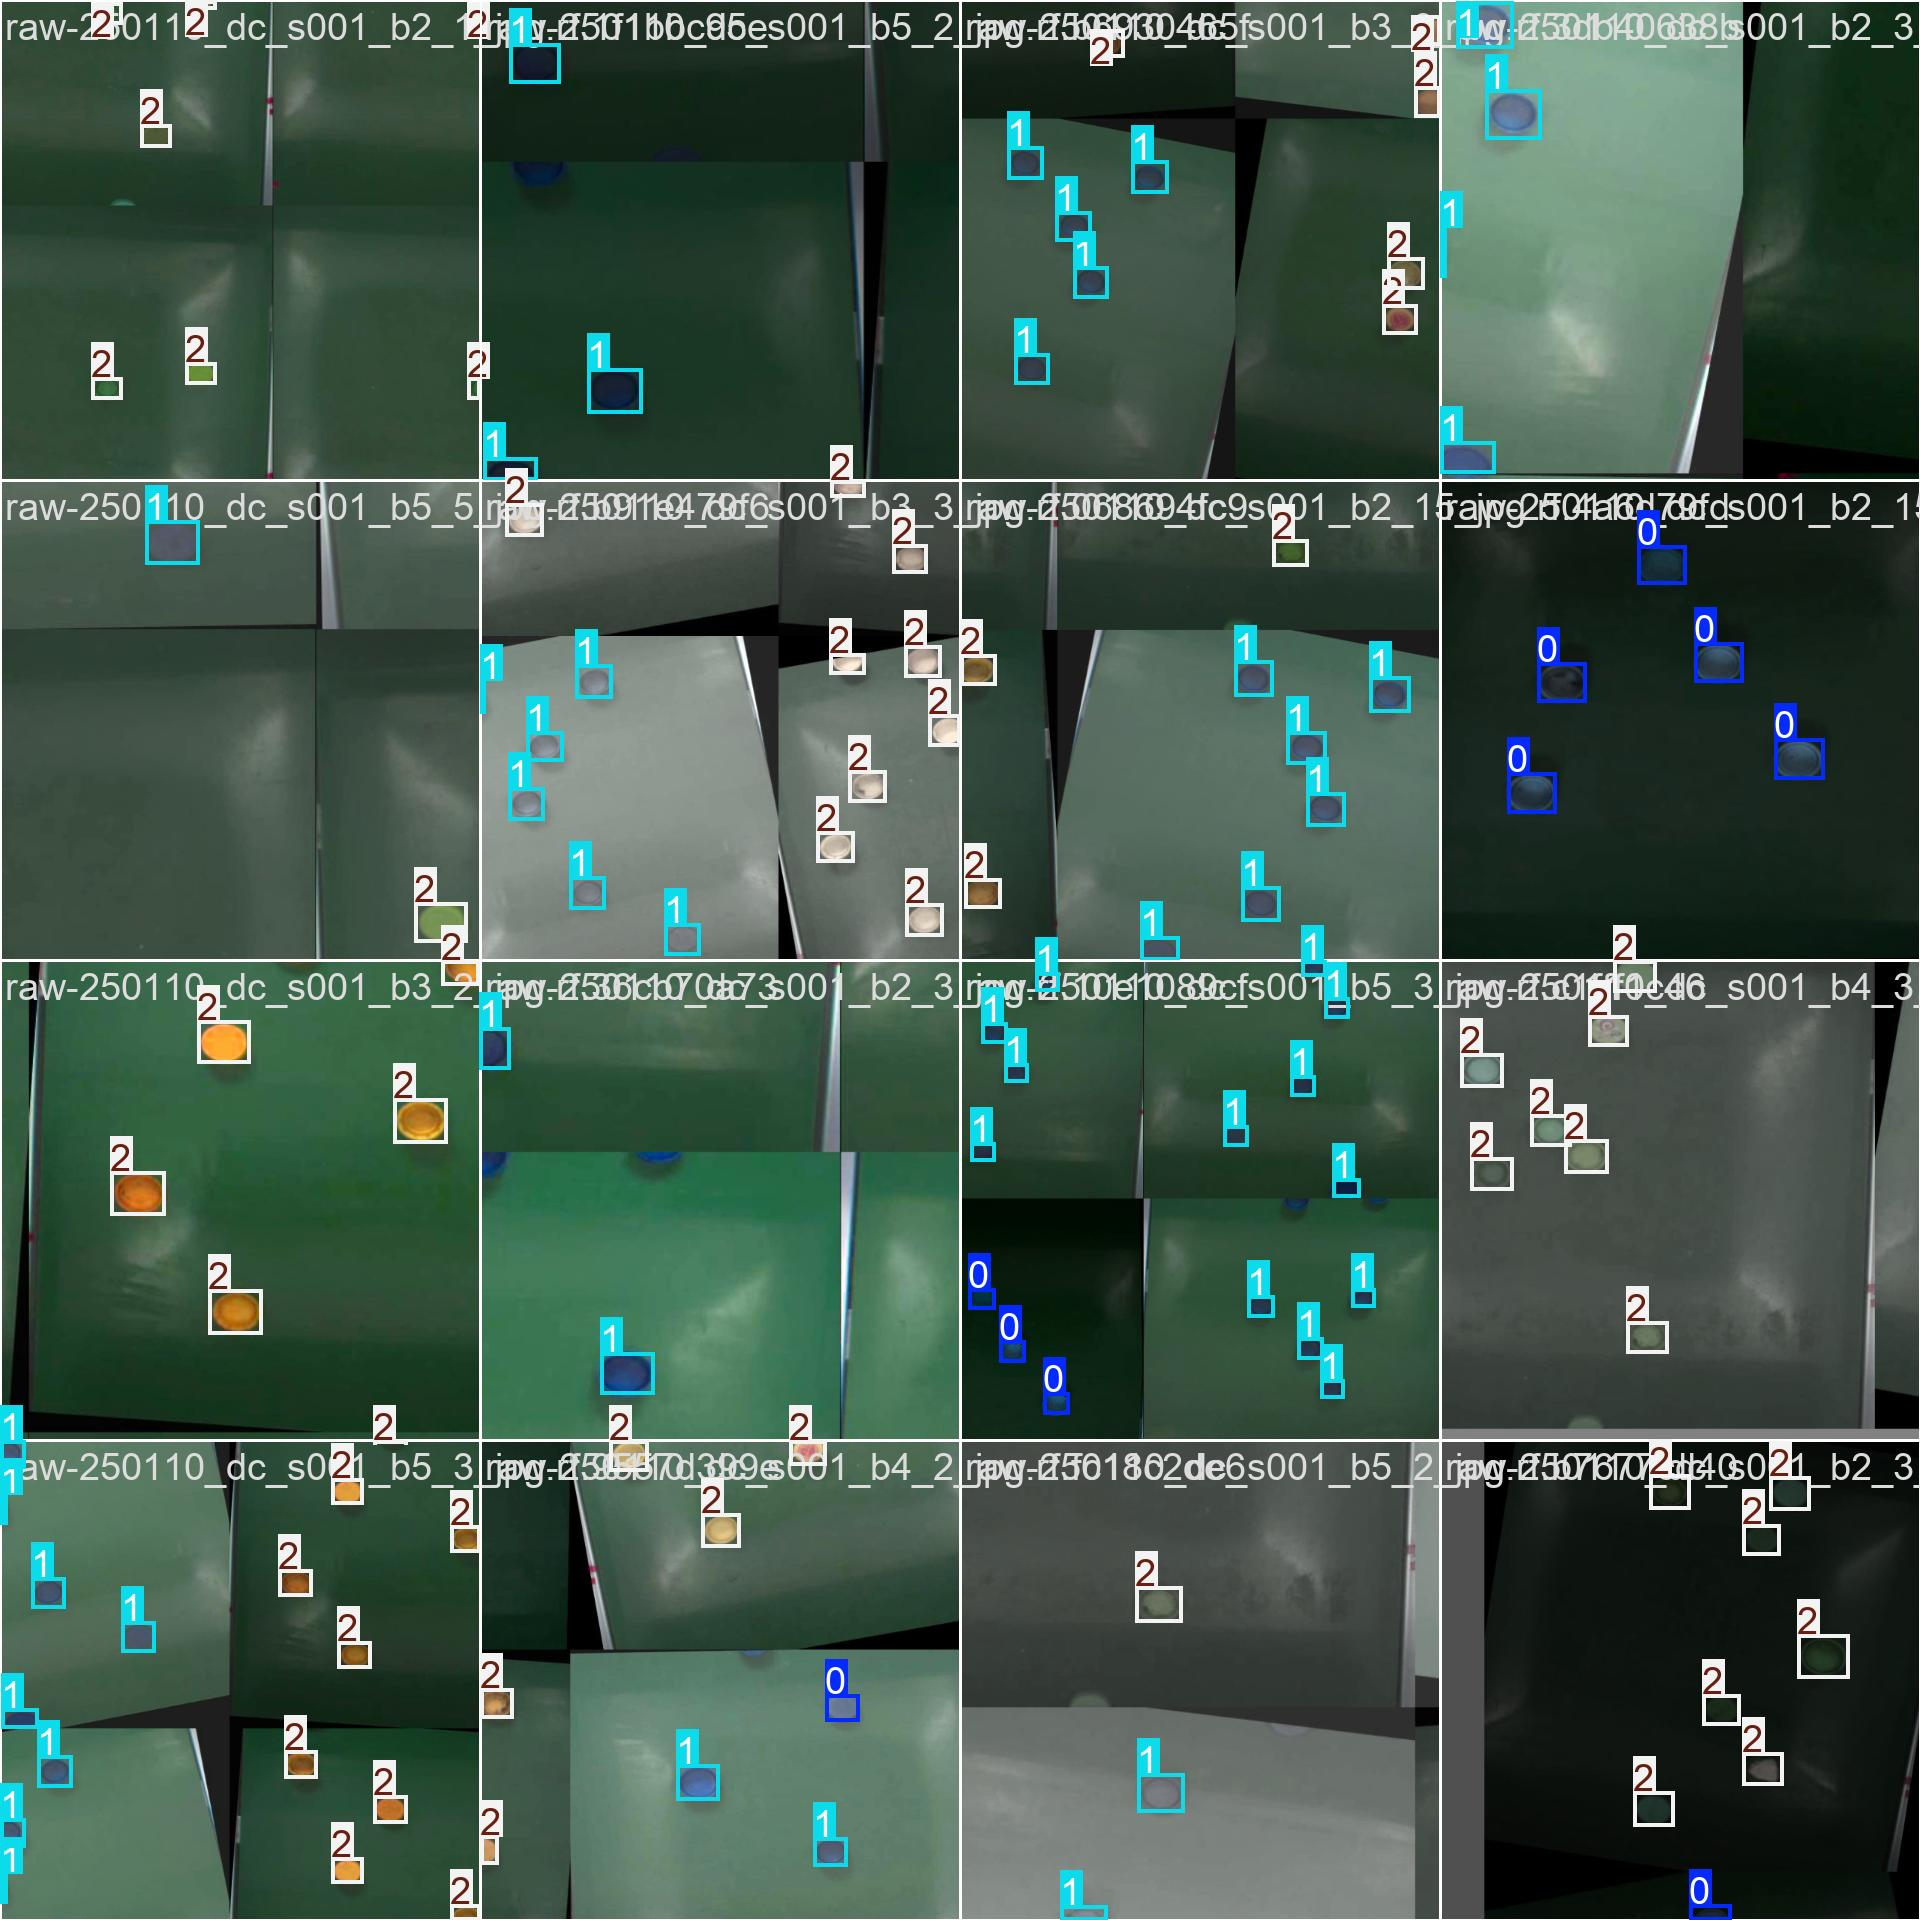

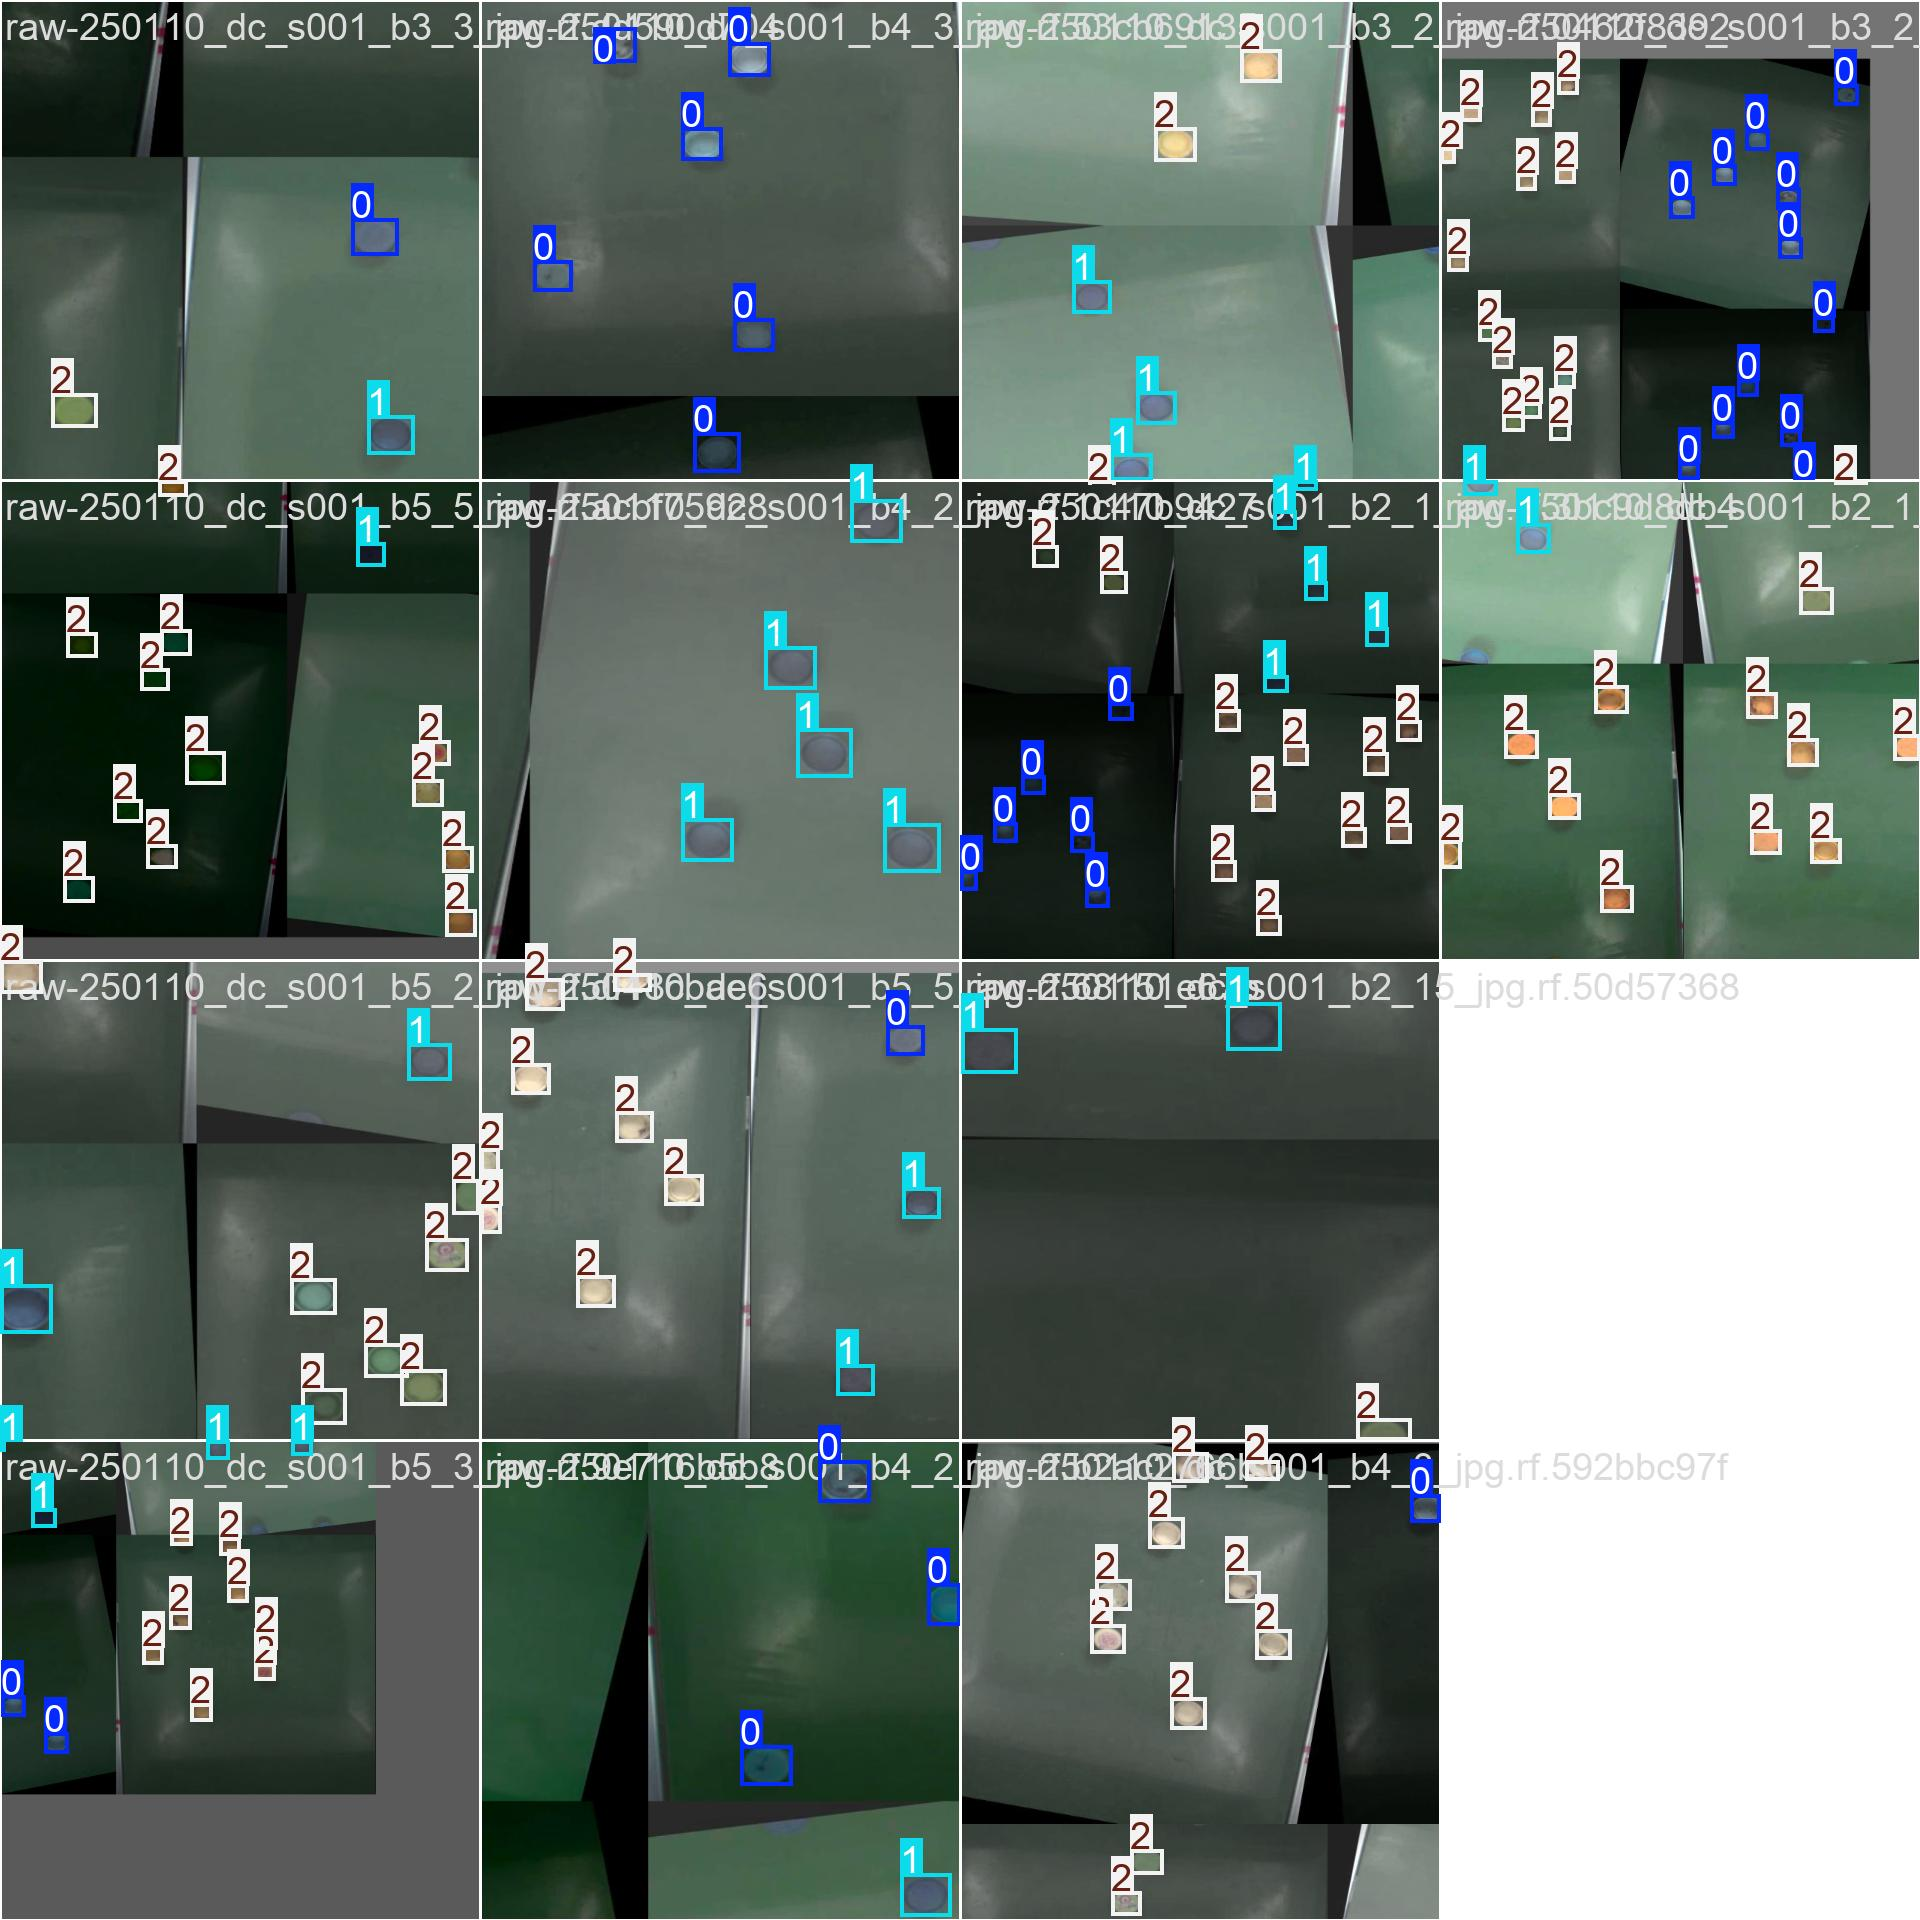

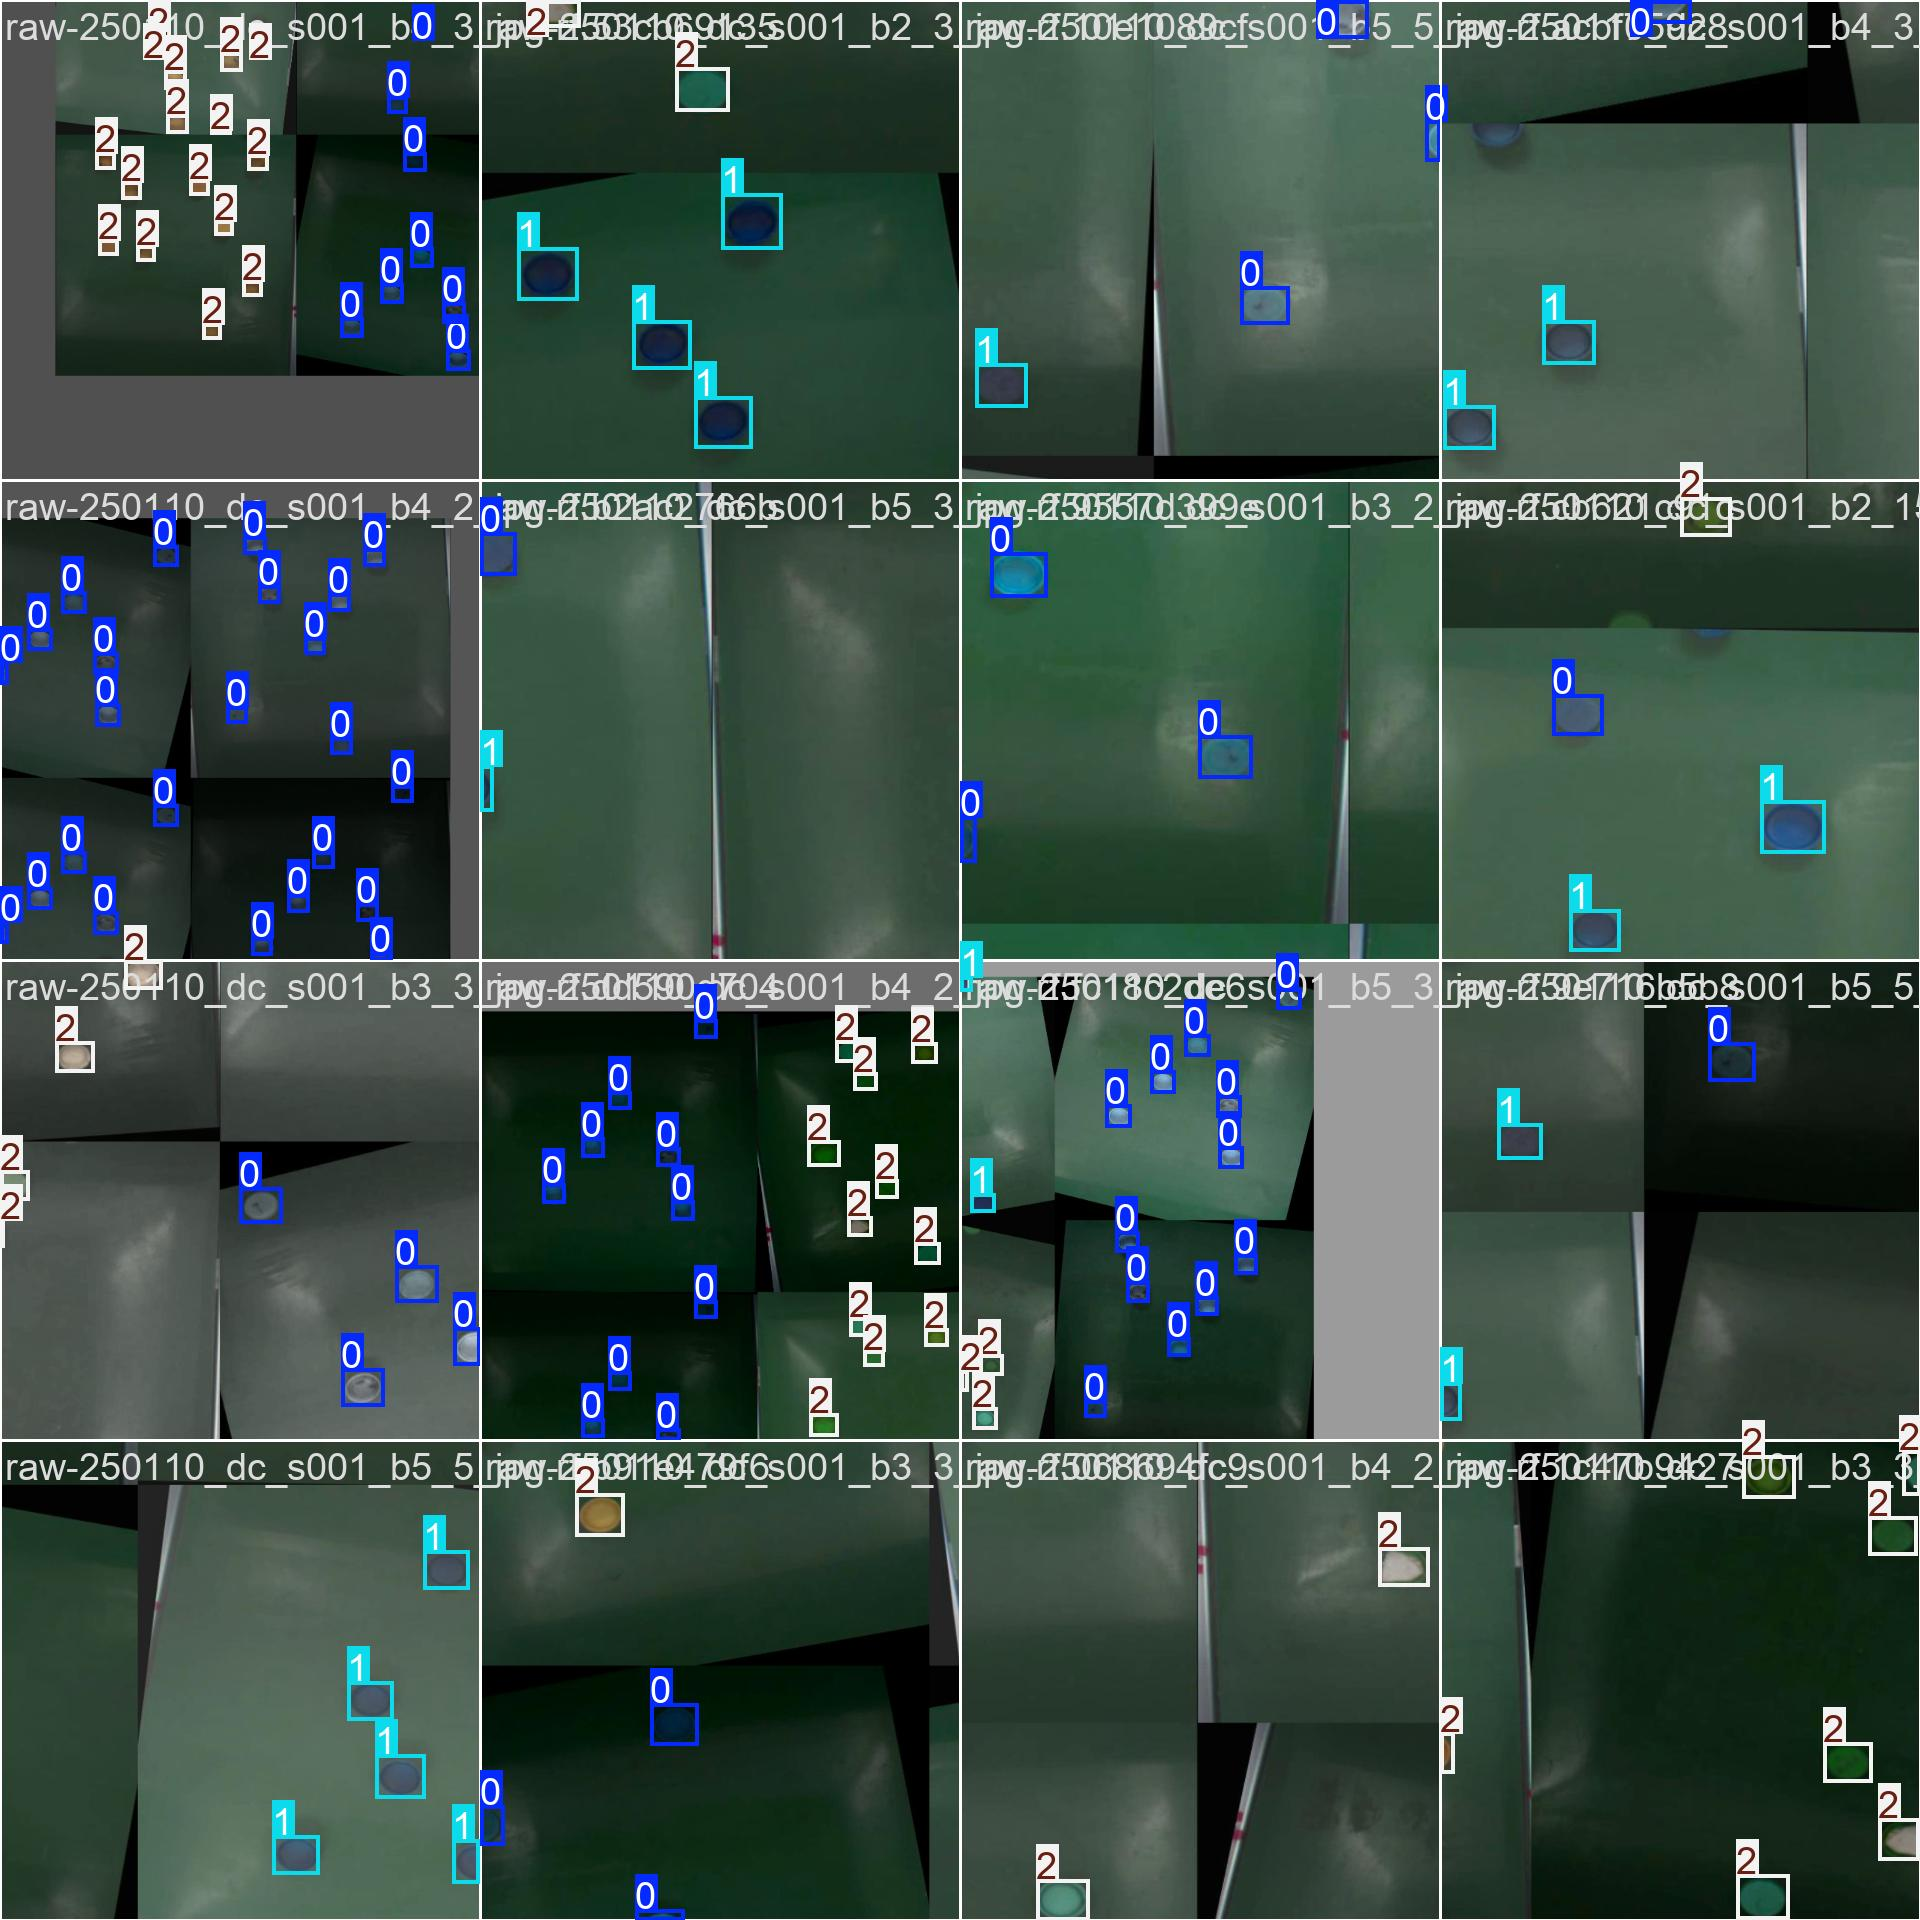

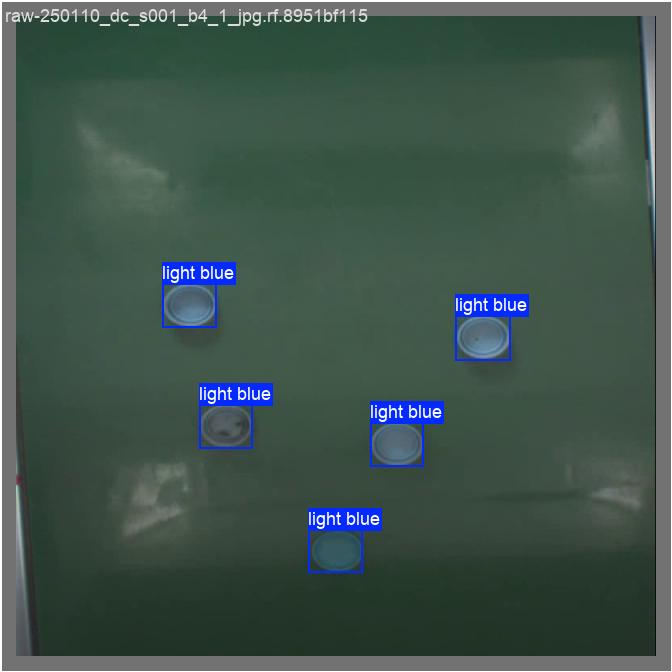

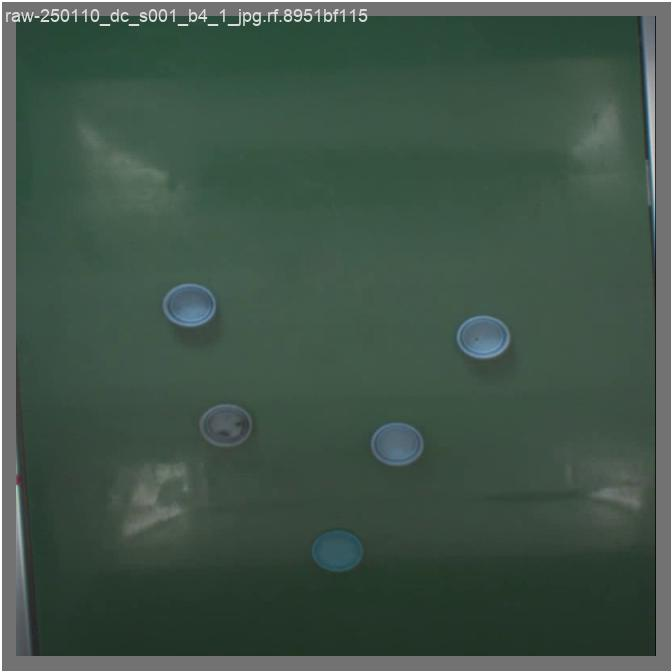

In [13]:
from IPython.display import display, Image
import os

# Path to the directory containing images
image_dir = 'Bottle-Caps-Detection/run4'

# List all files in the directory with valid image extensions
valid_extensions = ('.png', '.jpg', '.jpeg')
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(valid_extensions)]

# Display all images in the directory
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    display(Image(filename=image_path))

### Testing

In [15]:
# Load a pretrained YOLOv8 model
model = YOLO('Bottle-Caps-Detection/run4/weights/best.pt')

# Run validation on a set specified as 'val' argument
metrics = model.val(data='data.yaml', split="test")

Ultralytics 8.3.228  Python-3.11.5 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-12400F)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2.60.0 MB/s, size: 16.6 KB)
val: Scanning E:\Object Detection\Bottle Cap\test\labels... 1 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1/1 144.2it/s 0.0sScanning E:\Object Detection\Bottle Cap\test\labels... 1 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1/1 122.7it/s 0.0s
val: New cache created: E:\Object Detection\Bottle Cap\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 10.3it/s 0.1s
                   all          1         10     0.0775          1      0.995      0.814
                others          1         10     0.0775          1      0.995      0.814
Speed: 1.2ms preprocess, 45.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to E:\Object Detection\

### Testing Result

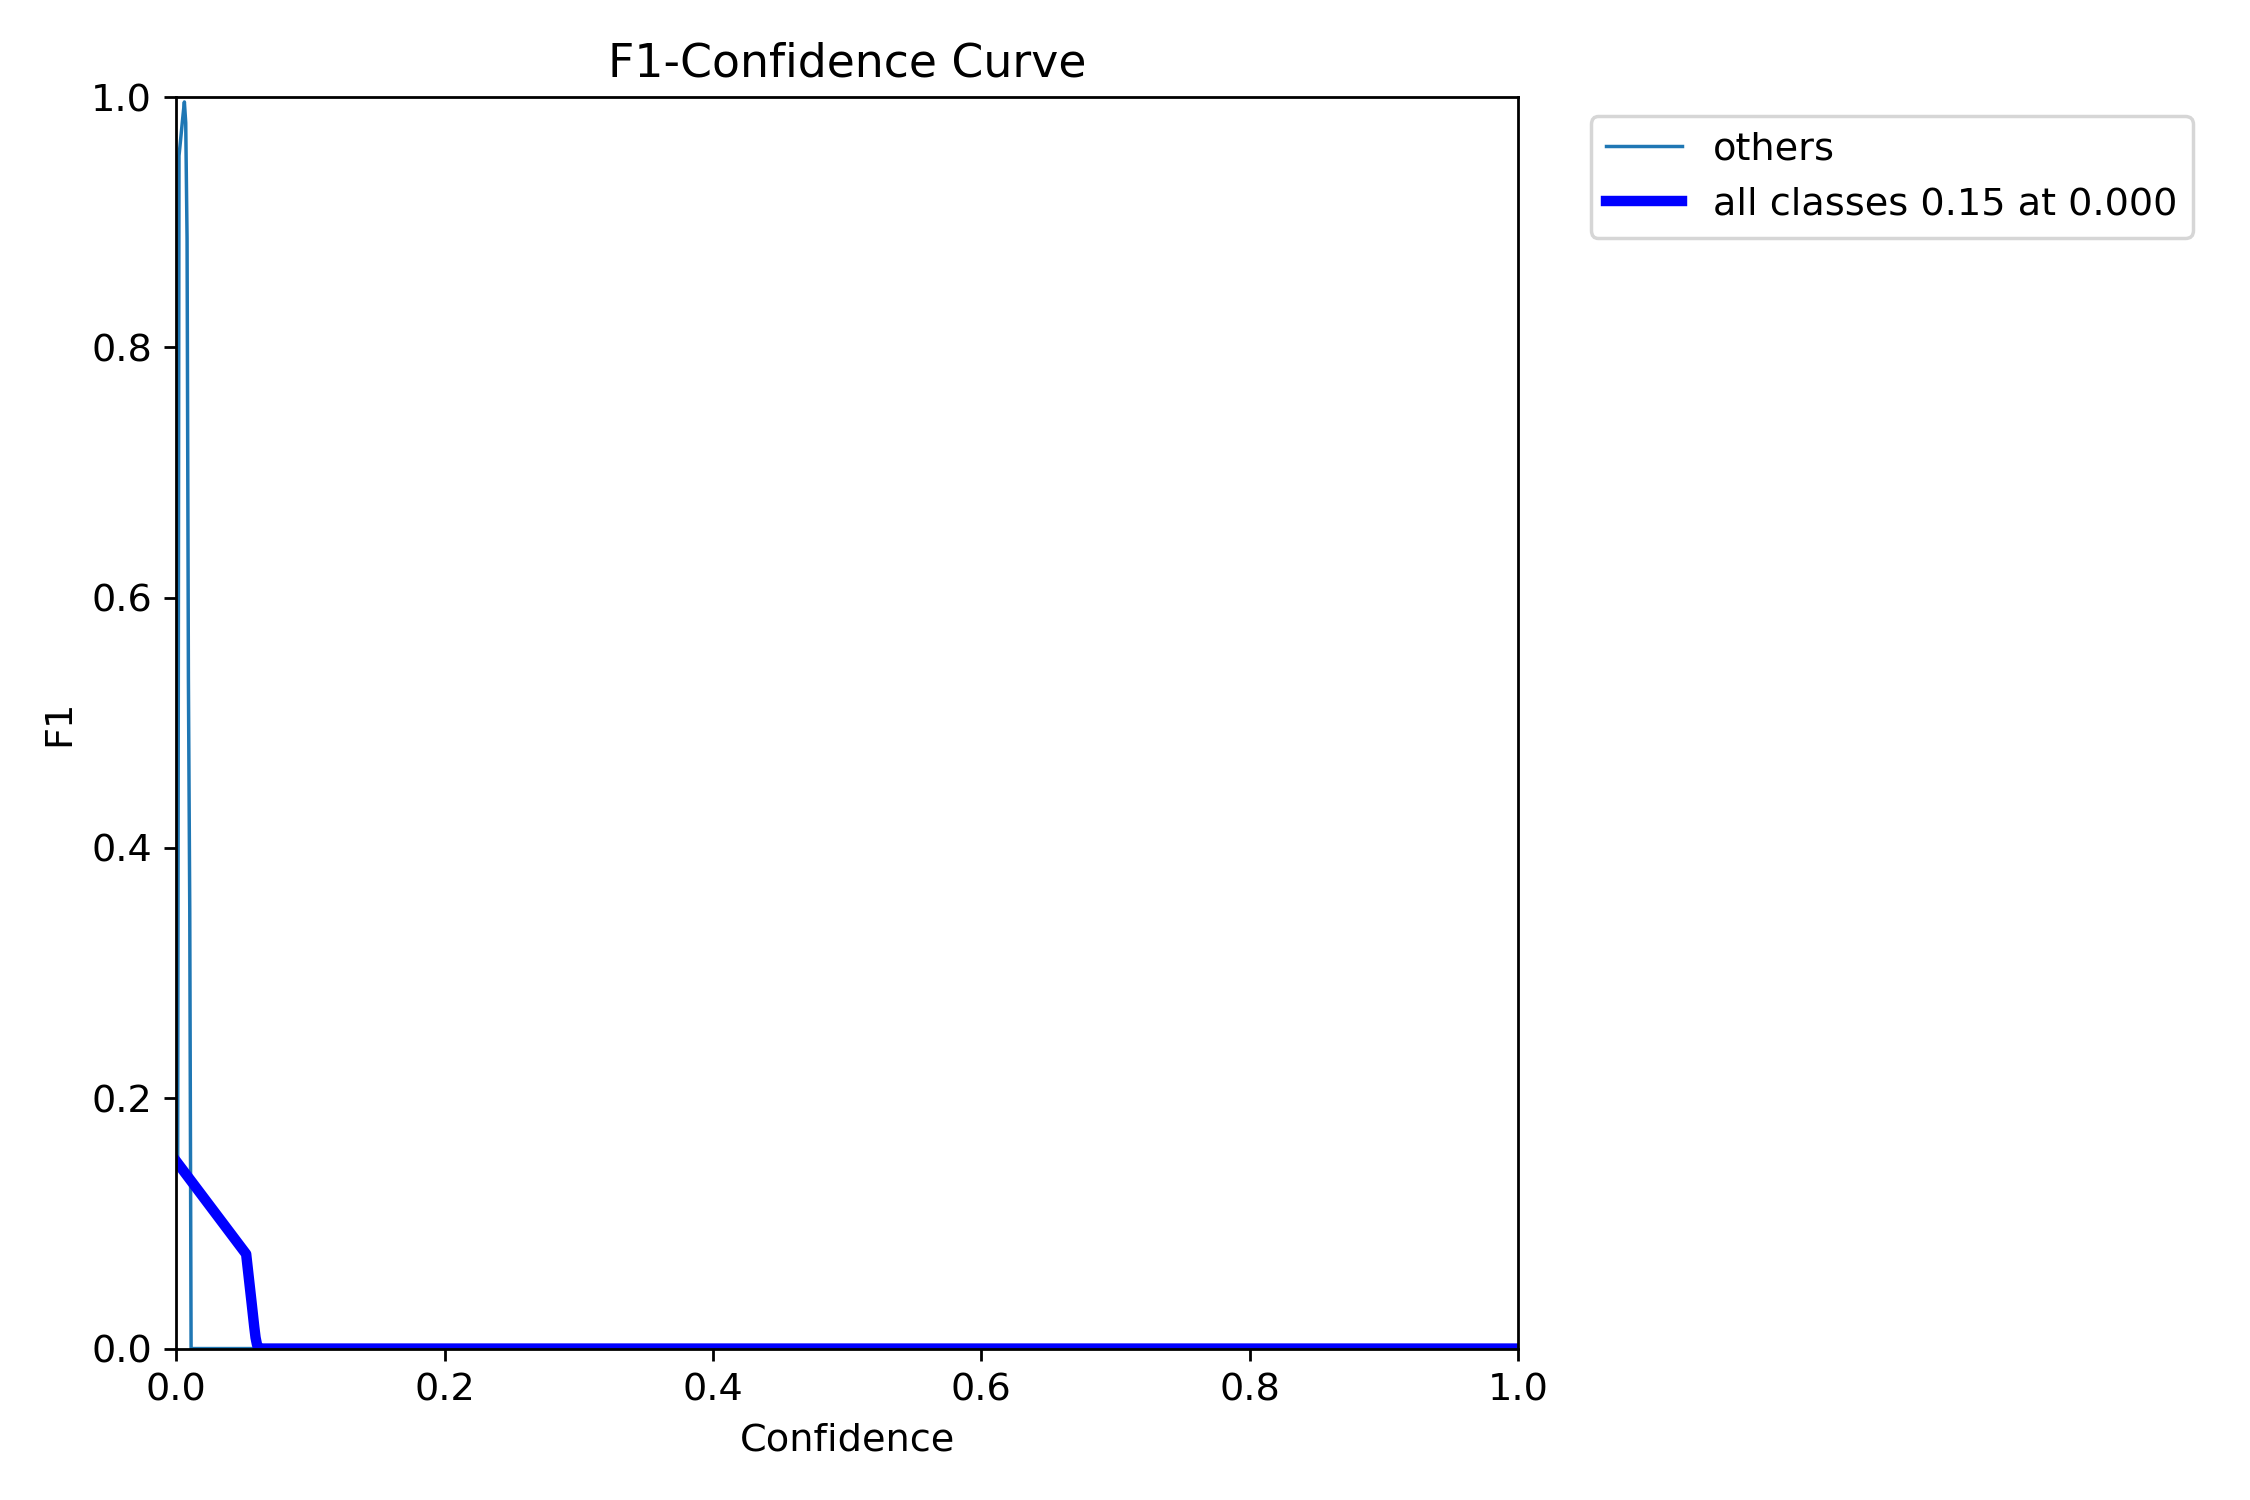

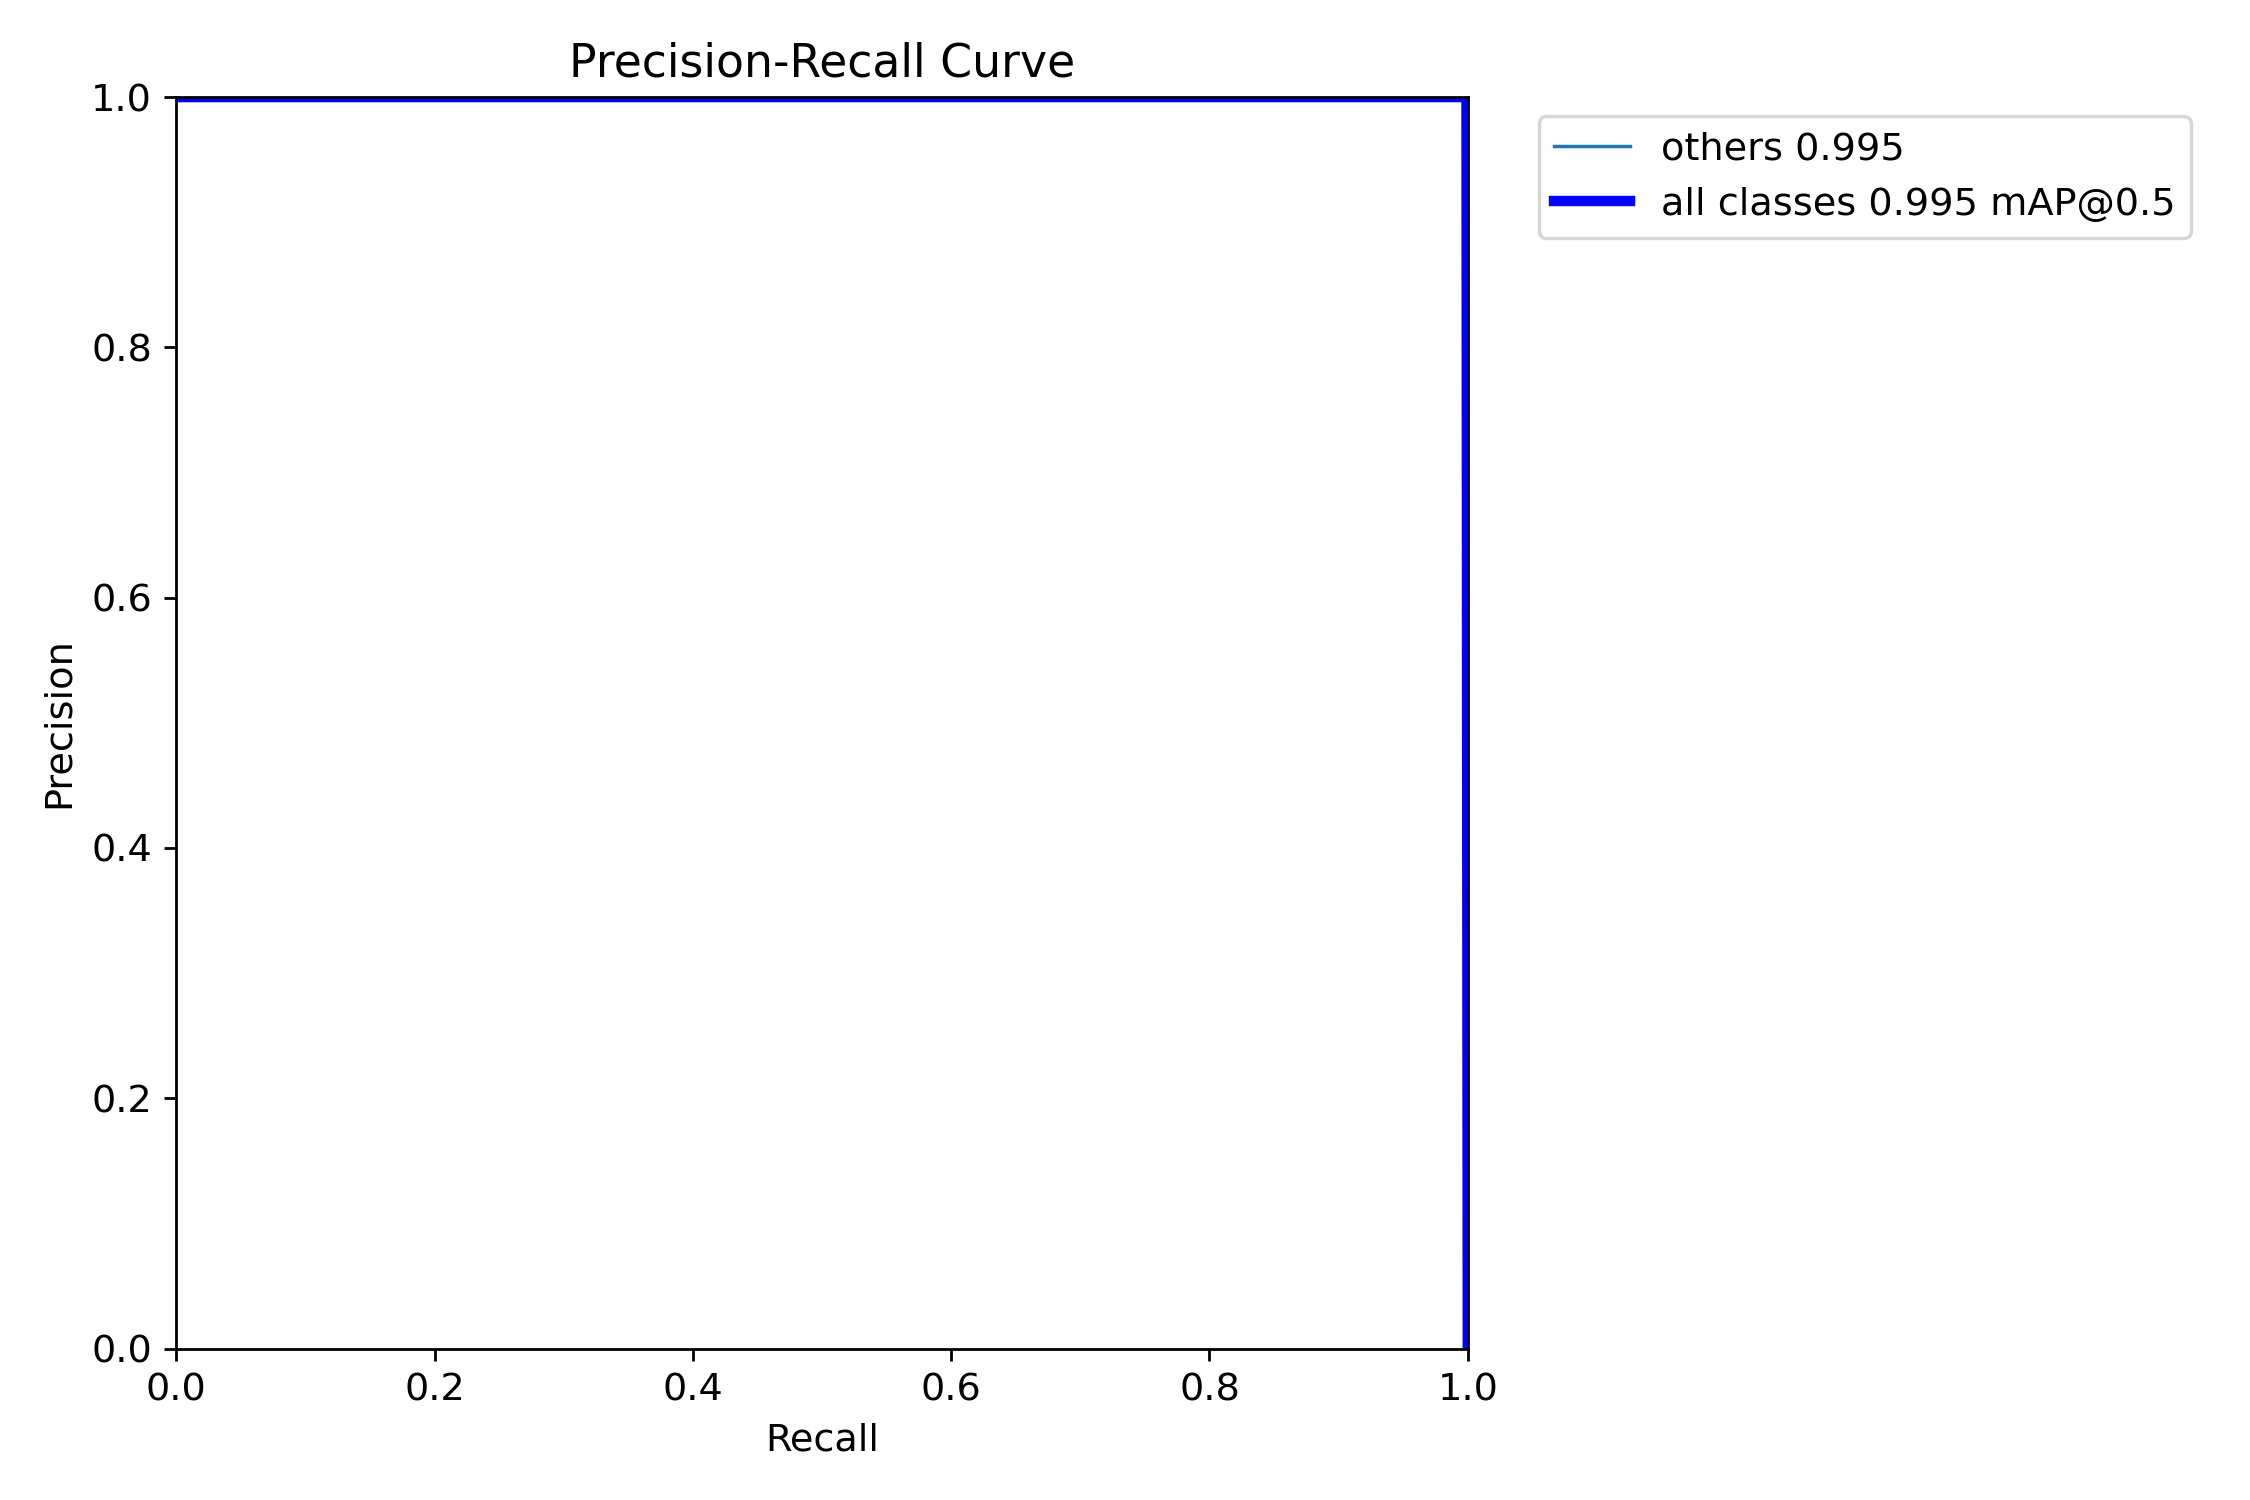

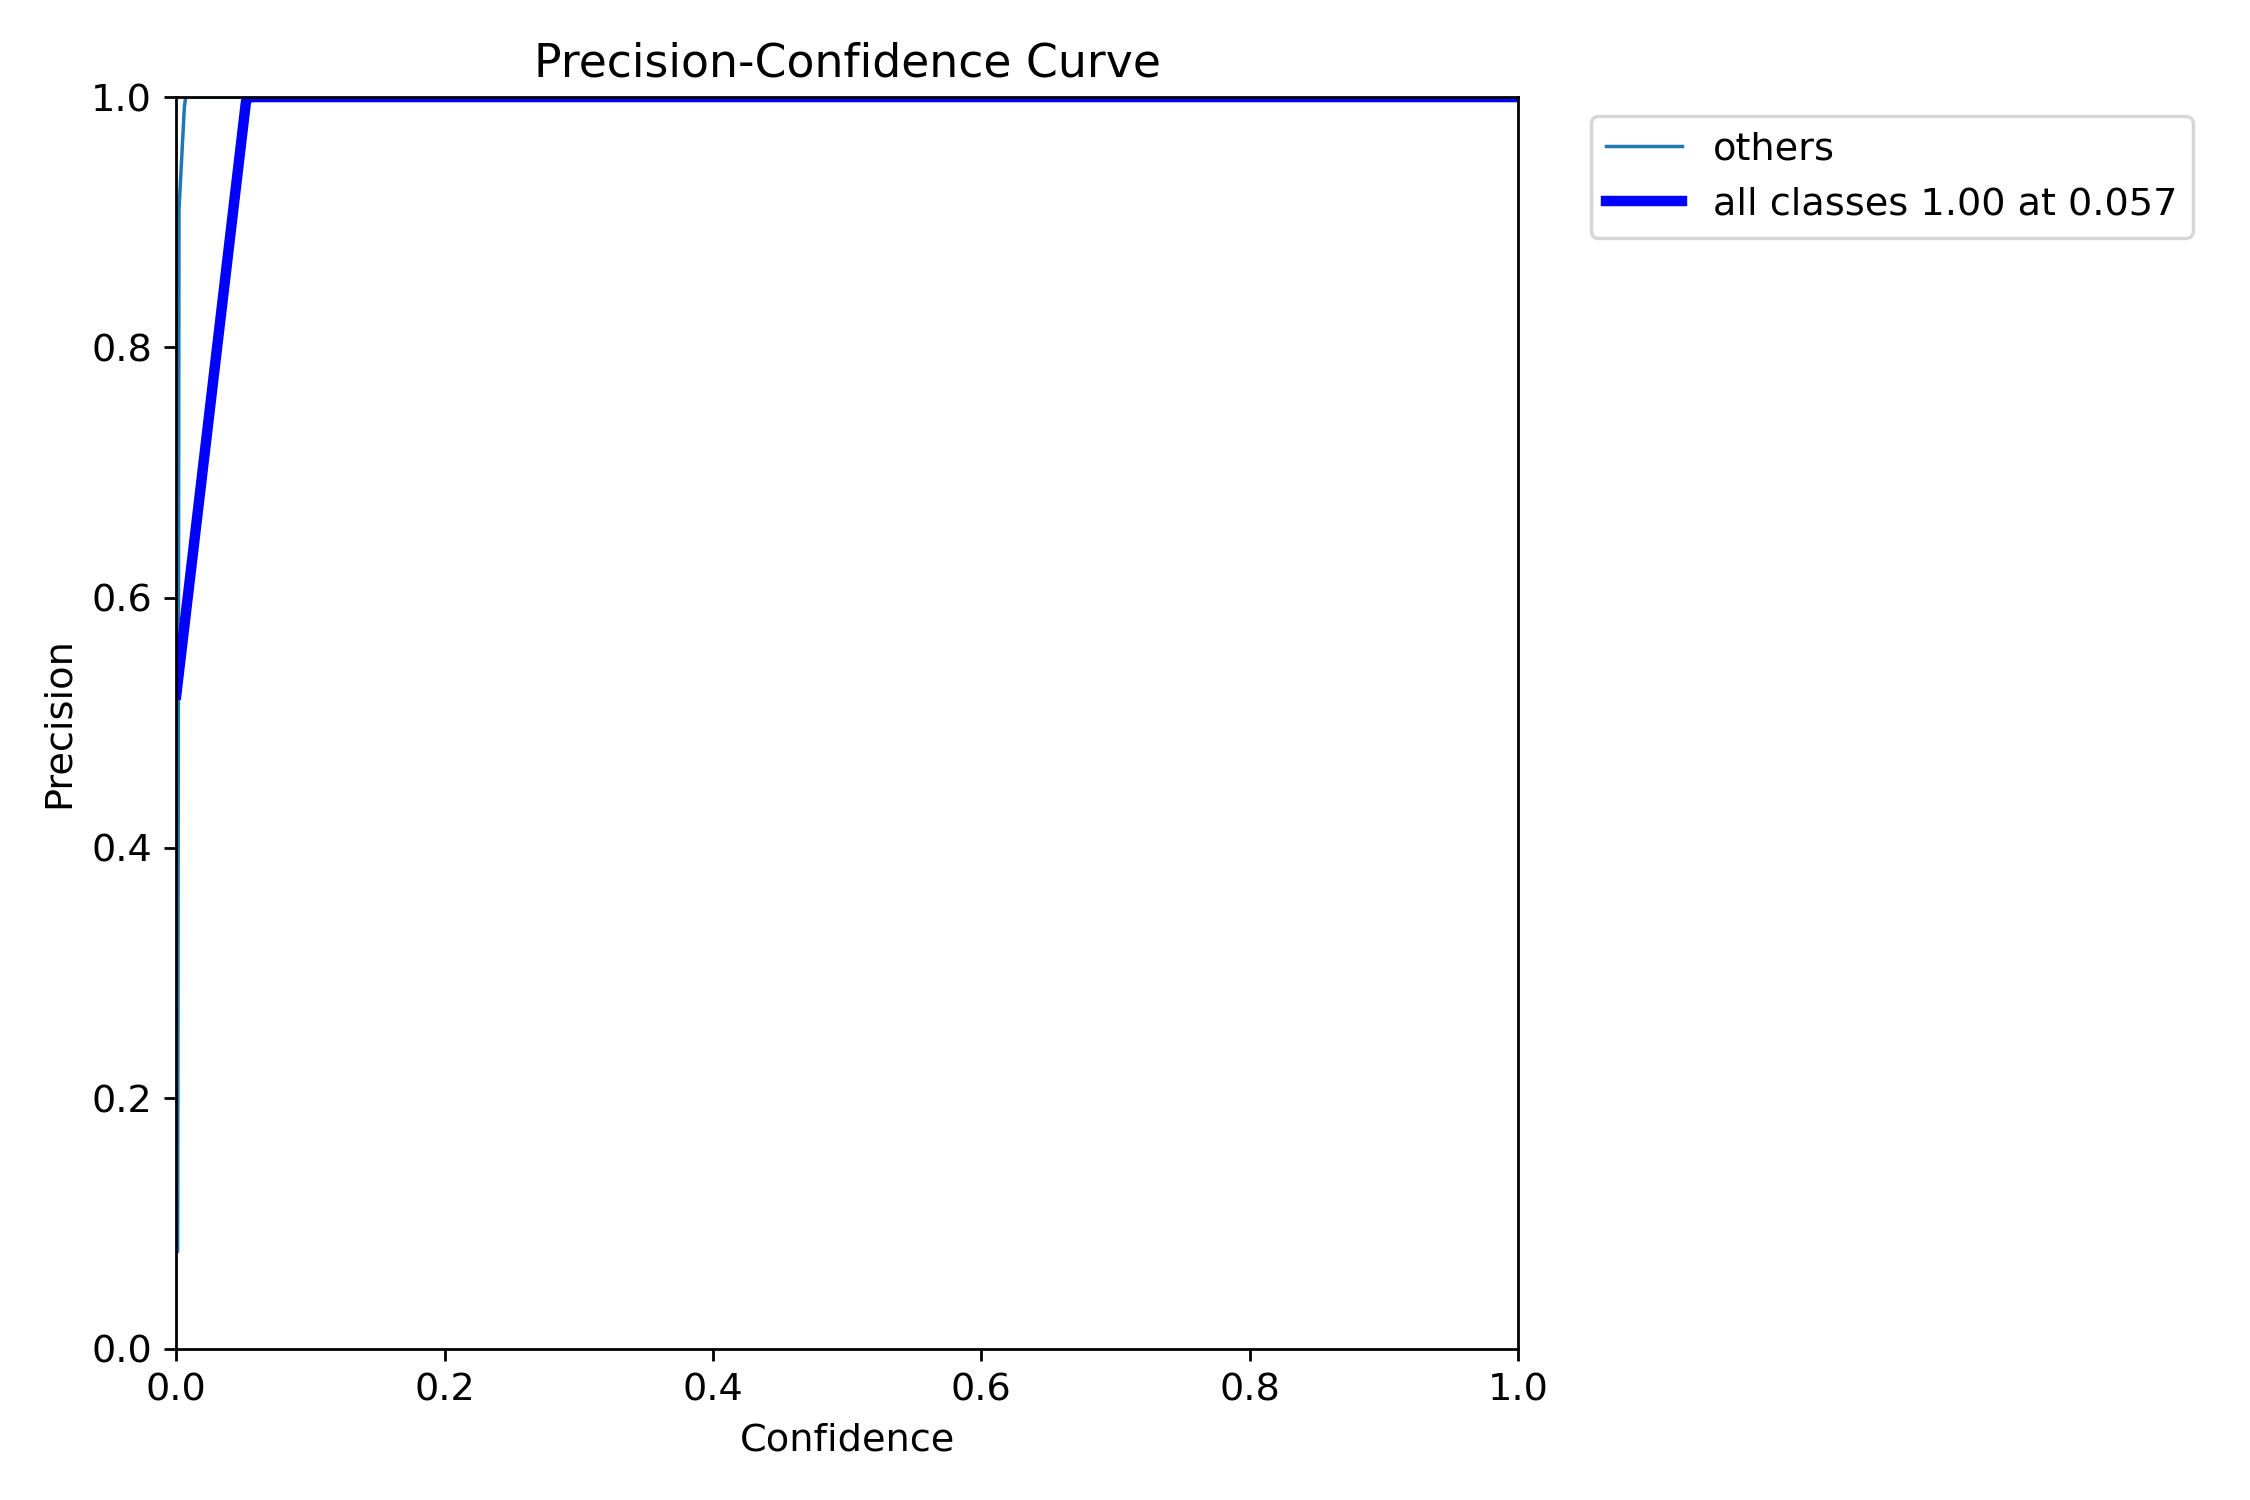

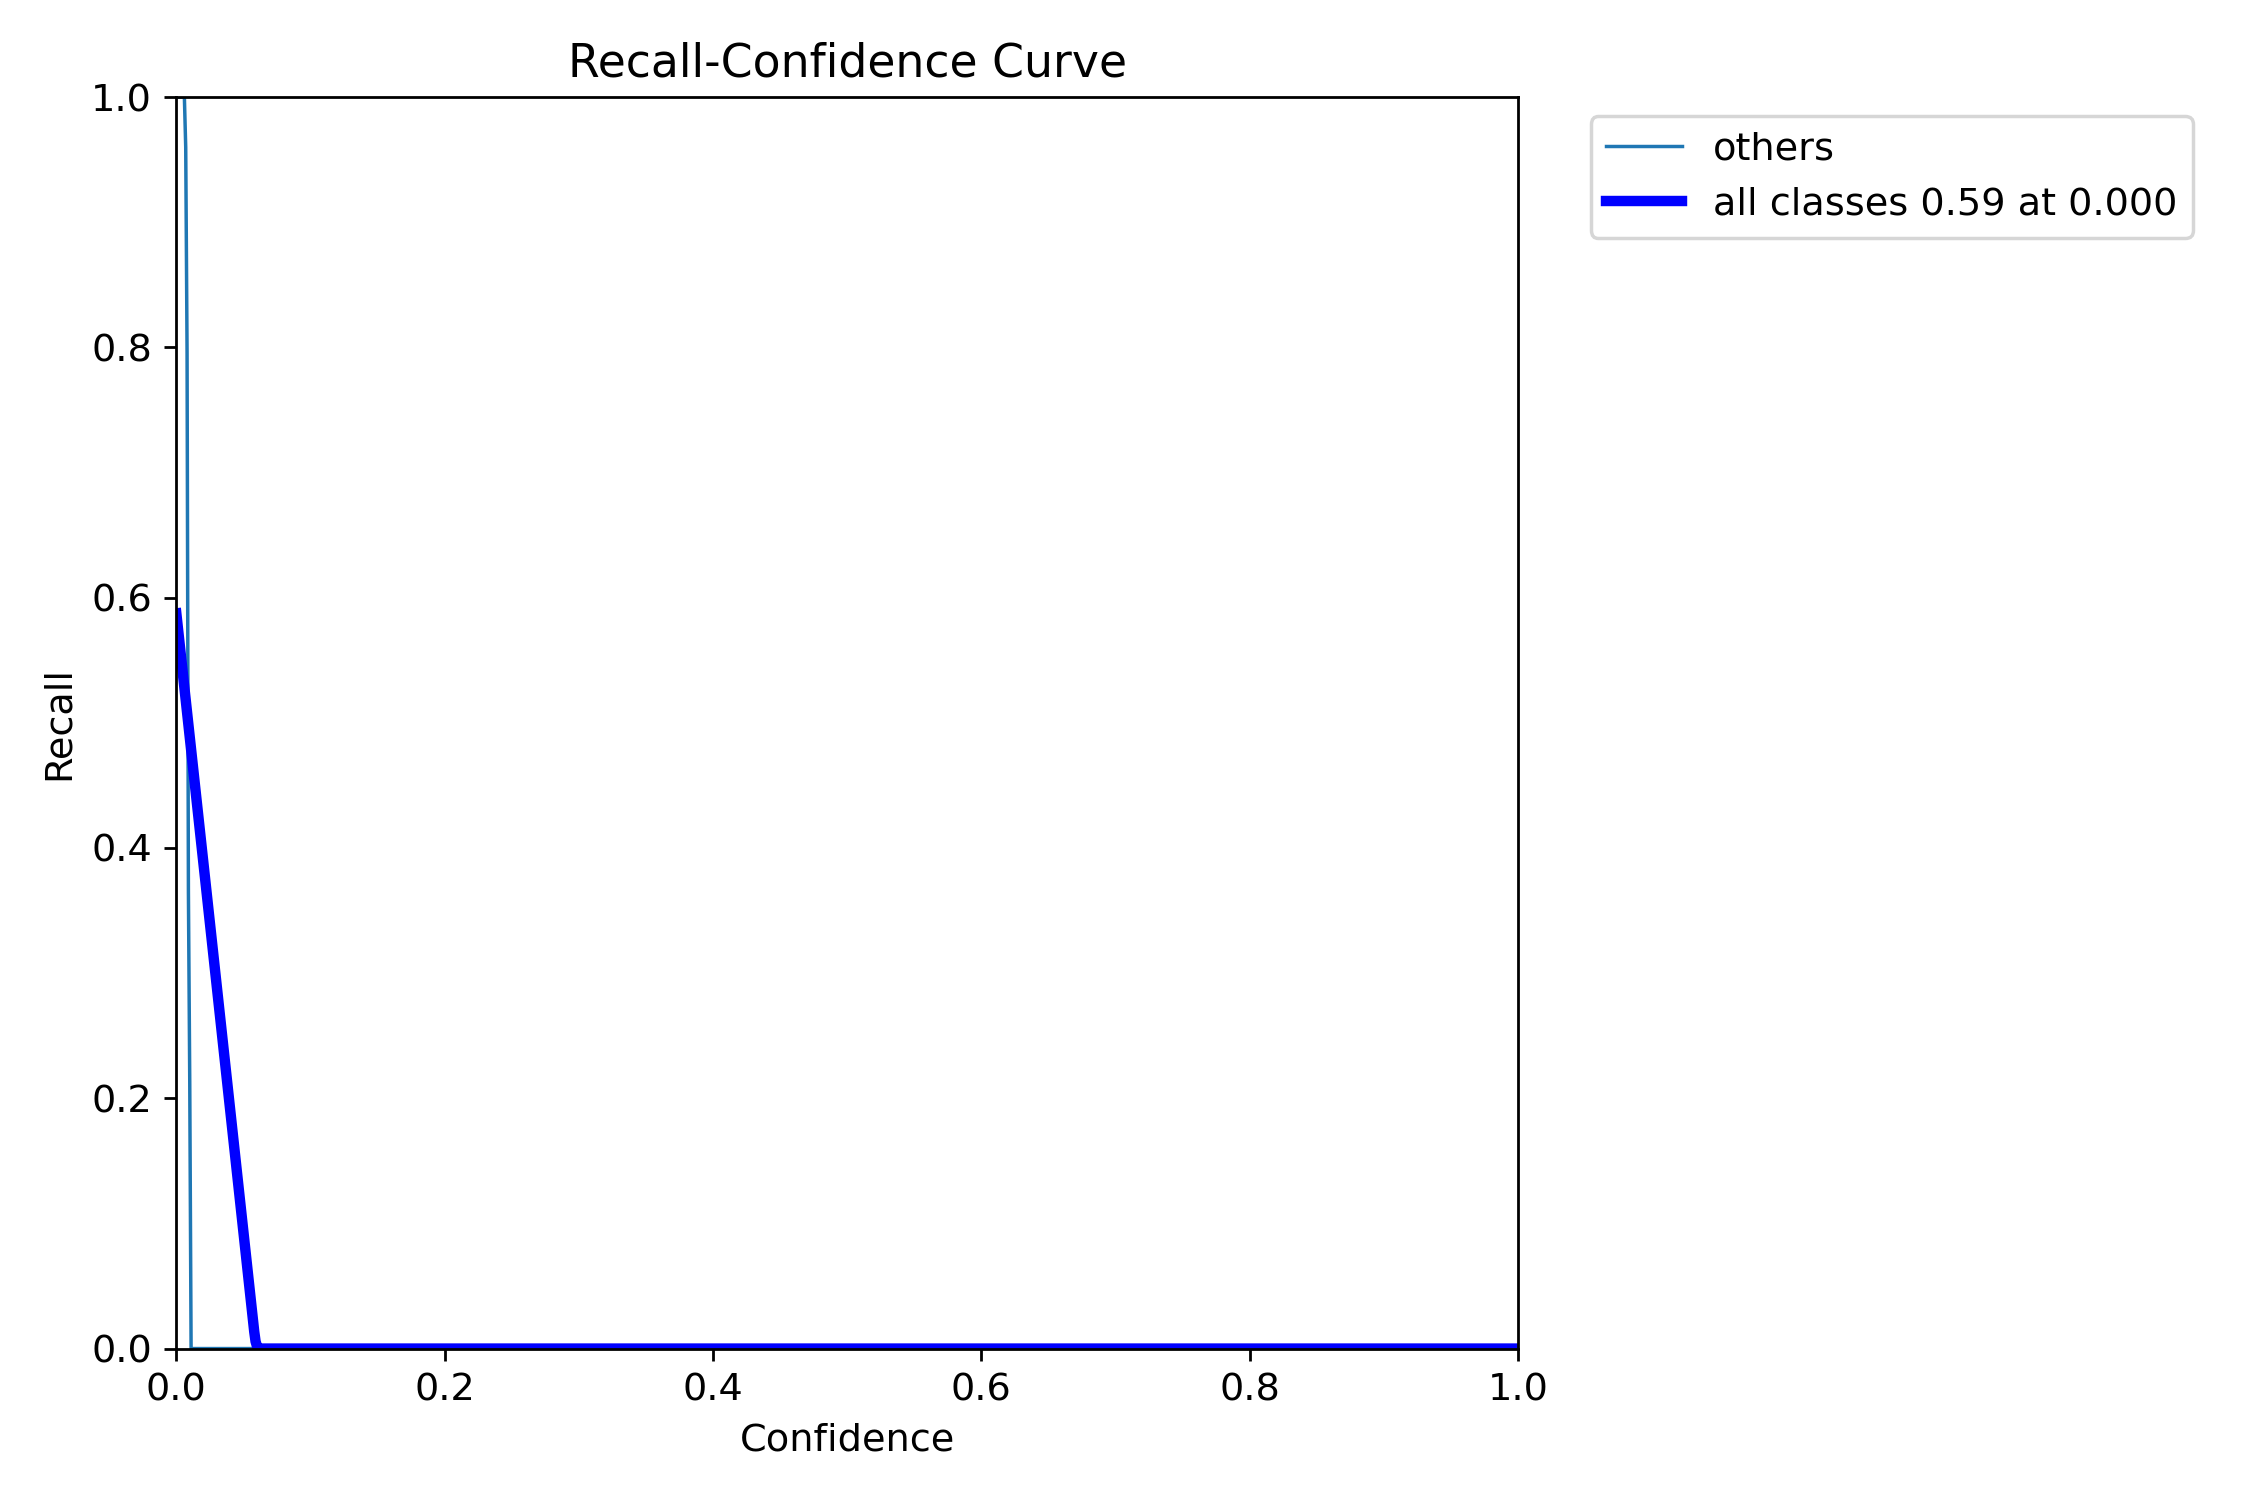

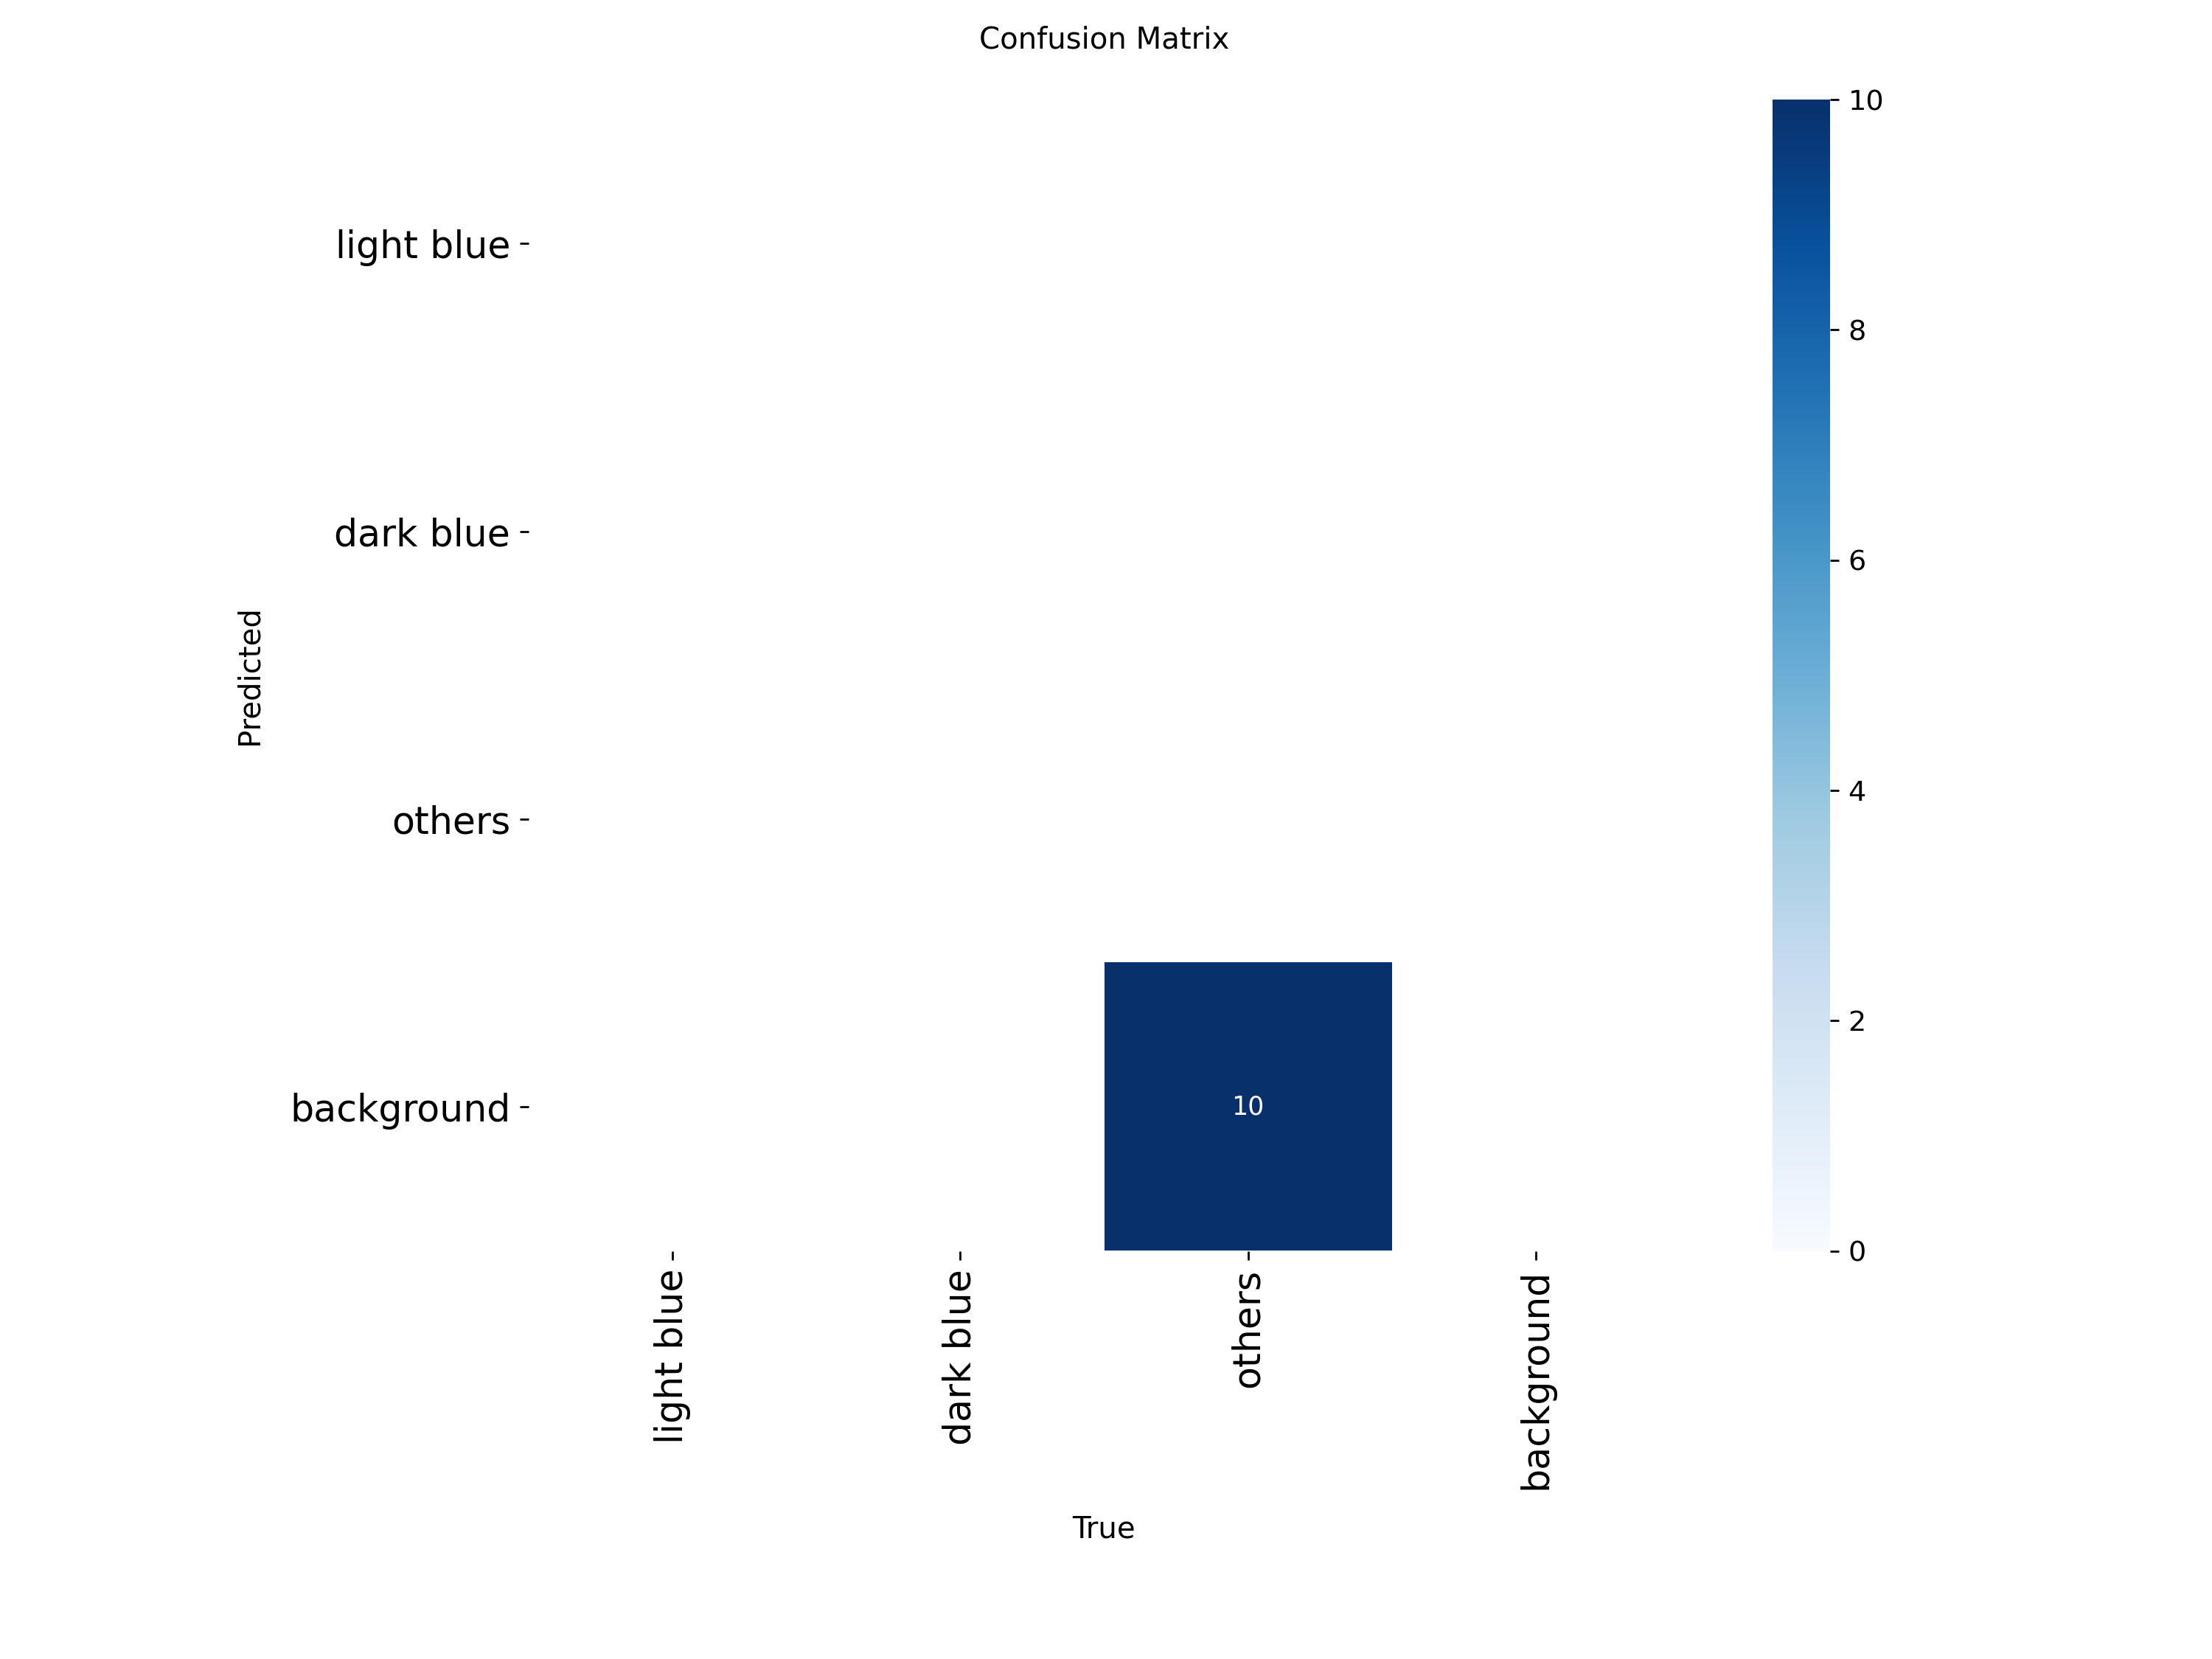

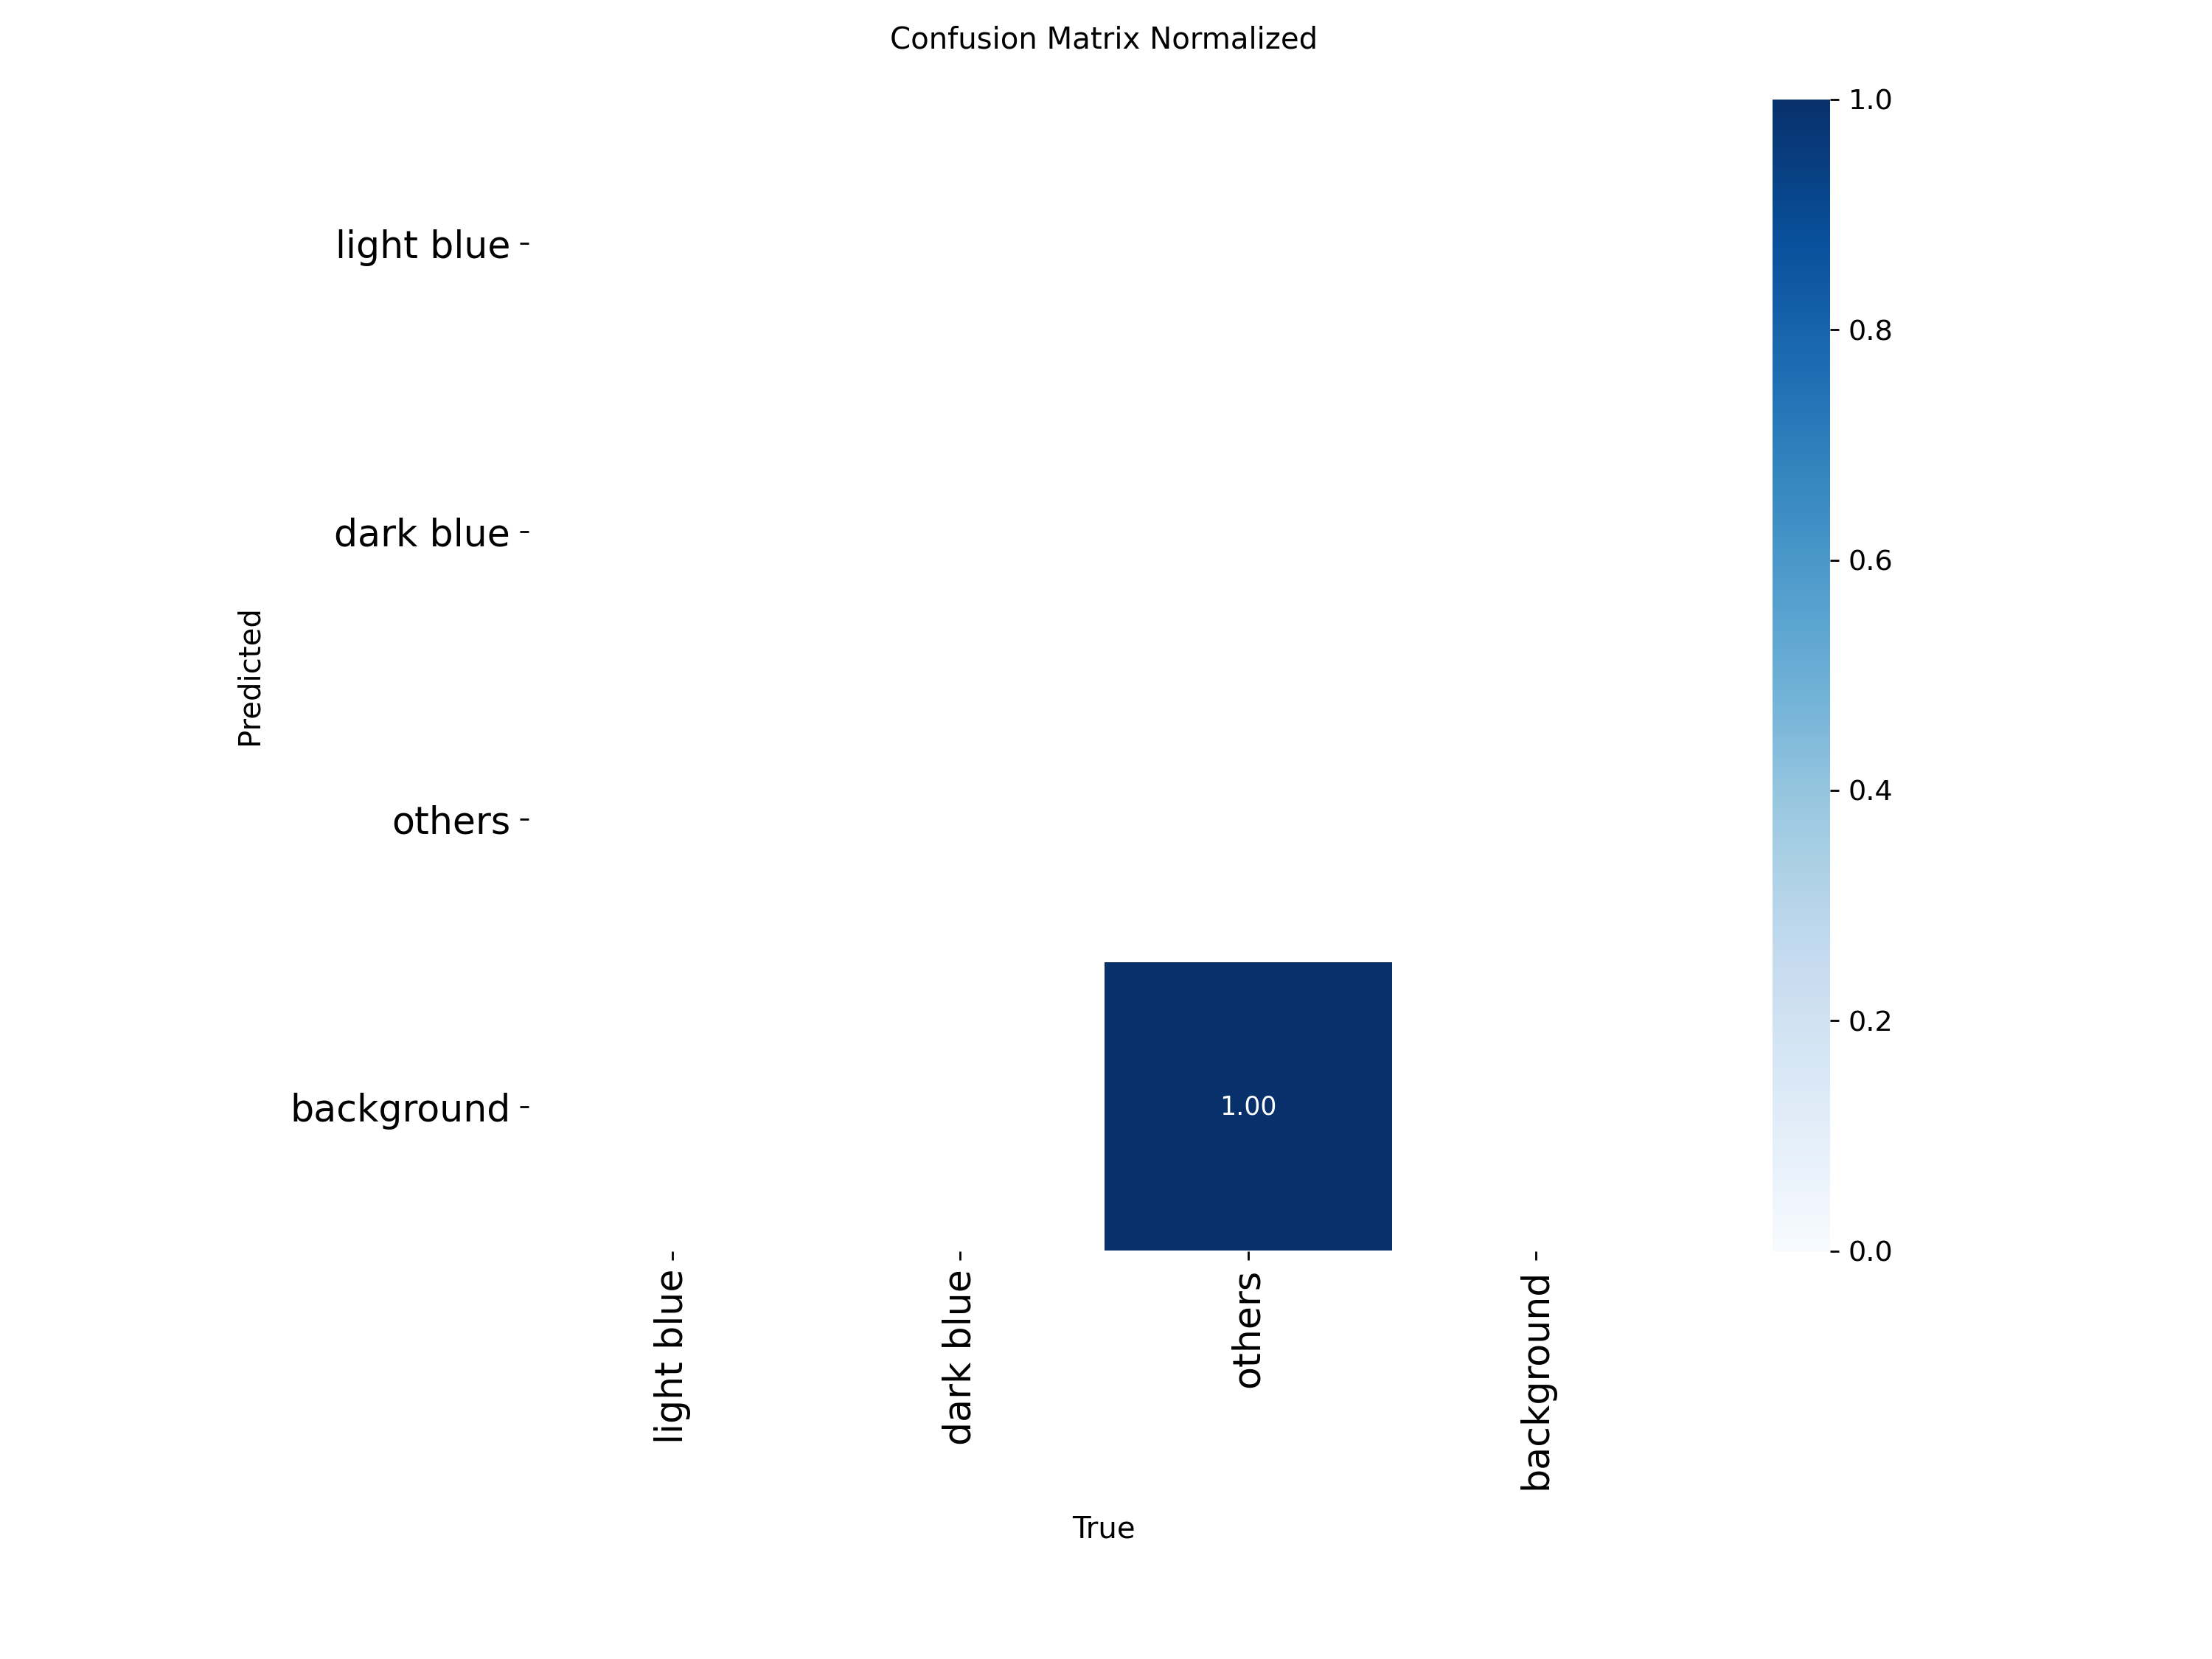

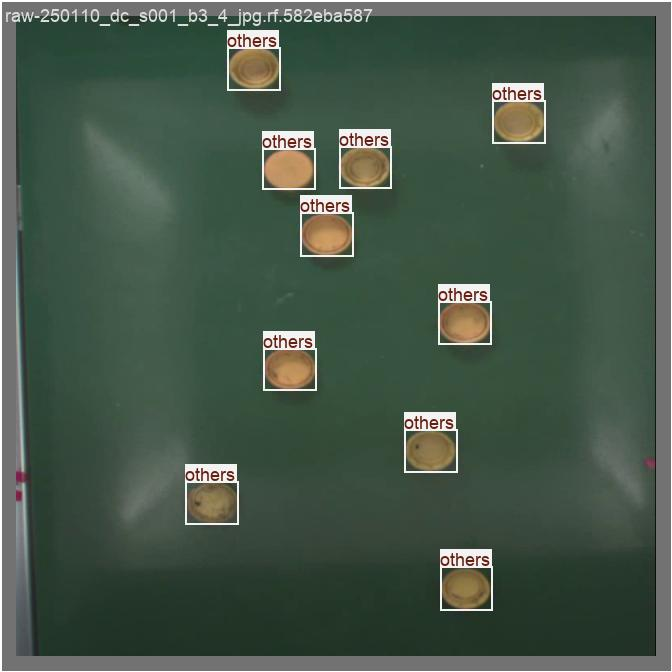

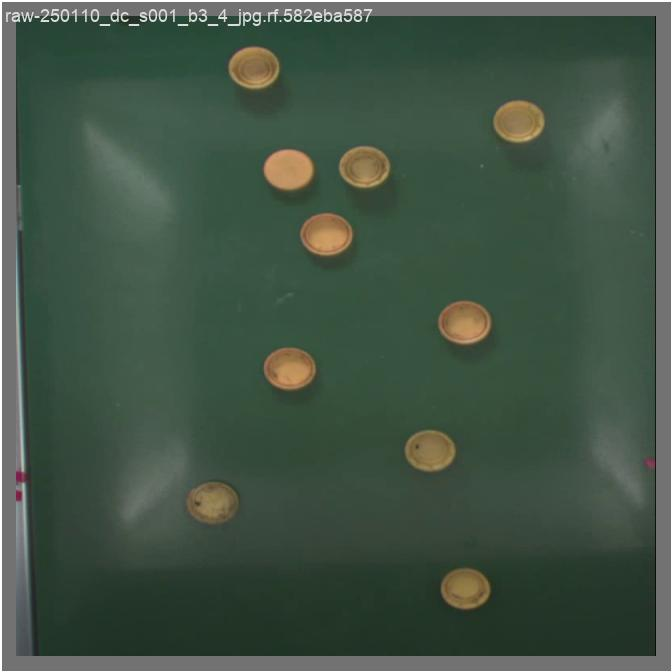

In [16]:
from IPython.display import display, Image
import os

# Path to the directory containing images
image_dir = 'runs/detect/val'

# List all files in the directory with valid image extensions
valid_extensions = ('.png', '.jpg', '.jpeg')
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(valid_extensions)]

# Display all images in the directory
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    display(Image(filename=image_path))

### 7. Evaluation & Result

Because the test set contains only 1 image, YOLOv8 does not generate meaningful evaluation charts such as PR curves, confusion matrix, or mAP plots. These charts require more samples to calculate distributions of true positives, false positives, and false negatives.

However, the model successfully predicted the object and classified its color correctly on the test image.
This indicates that:

- The model can generalize slightly beyond the training set

- The detection head is functioning correctly

- The color classification logic (light blue, dark blue, others) works on at least one unseen sample

Still, the absence of test metrics means that no statistical conclusion can be drawn from the test performance.

### 8. Dataset Bias and Limitations

The dataset used for training has several severe limitations that strongly affect model reliability:

#### 8.1 Extremely Small Dataset
Only 12 total images are available. Even after splitting:

Train: 10 images
Validation: 1 image
Test: 1 image

This size is far below what is normally required for object detection tasks (typically thousands).

#### 8.2 Severe Class Imbalance

The majority of labels belong to “others”, while:

Light blue = ~1–2 samples
Dark blue = ~1–2 samples
Others = majority

This leads to:

Model bias toward predicting the dominant class ("others")
Unstable validation metrics
Higher classification loss early in training
Difficulty in distinguishing light vs dark blue consistently

#### 8.3 Overfitting Risk

Because the dataset is so small, the model quickly overfits:

Training losses decrease smoothly
Validation losses decrease but fluctuate heavily
mAP values jump drastically from one epoch to another
This is expected behavior when the validation set consists of only one image.

#### 8.4 Lack of Real-World Variations

The dataset lacks variety in:

Lighting

Color shades

Angles

Backgrounds

Bottle cap shapes/sizes

This limits the generalization ability of the model.

### 9. Model Performance Summary

Despite the dataset limitations:

The training curves show that the model successfully learns detection and classification patterns.
Validation losses eventually stabilize, indicating some generalization.
Precision, recall, and mAP rise significantly after ~15 epochs, but these metrics are not reliable due to tiny validation size.
The model correctly predicts the test image (a positive qualitative result.)

Therefore:

The model performs well on the small available dataset but cannot be considered production-ready due to lack of data quantity and diversity.

### 10. Recommendations and Future Improvements

To achieve meaningful and reliable performance, the following improvements are recommended:

**10.1 Expand the Dataset** 

At least 200–500 images per color class are needed to train a stable model.

**10.2 Improve Class Balance** 

Ensure similar number of images for:

Light blue

Dark blue

Others

This will reduce classification bias.

**10.3 Add More Augmentations** 

**Since data is limited, stronger augmentations can help:** 

Color jitter

Hue saturation shift

Random cropping

Perspective transform

Background replacement

**10.4 Use Synthetic Data** 

If collecting more data is difficult, synthetic bottle-cap images can be generated.

**10.5 Use a Simpler Model for Edge Devices** 

YOLOv8n is already lightweight, but for Raspberry Pi 5:

Reduce image size 

Export to ONNX or TensorRT

Use quantization (INT8) for faster inference (5–10ms target)

### Converting YOLOv8 (pytorch) to ONNX

In [ ]:
from ultralytics import YOLO

model = YOLO("models/best.pt")

print("Mengekspor model ke ONNX...")

# 2. Jalankan EXPORT ke ONNX
model.export(
    format="onnx",
    imgsz=224
)

print("Selesai! File .onnx baru telah dibuat.")